In [1]:
import pprint
import rasterio
from rasterio import features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

In [2]:
# Base values
channel_descriptions = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'pdsi', 'LC_Type1', 'total_precipitation_surface_last', 'forecast wind speed', 'forecast wind direction', 'forecast temperature', 'forecast specific humidity', 'active fire']

min_values = [np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-9863.268),
  np.float32(-4422.217),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-84.0),
  np.float32(-6.72),
  np.float32(1.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-89.999214),
  np.float32(-13.984883),
  np.float32(0.0),
  np.float32(0.0)]

max_values = [np.float32(15976.0),
  np.float32(15799.0),
  np.float32(15744.0),
  np.float32(9975.073),
  np.float32(9856.787),
  np.float32(122.0),
  np.float32(16.2),
  np.float32(360.0),
  np.float32(311.8),
  np.float32(325.4),
  np.float32(122.0),
  np.float32(0.01888),
  np.float32(63.85685),
  np.float32(359.42383),
  np.float32(4268.336),
  np.float32(8.28),
  np.float32(17.0),
  np.float32(204.1875),
  np.float32(14.295916),
  np.float32(89.98897),
  np.float32(39.505894),
  np.float32(0.0122514665),
  np.float32(2218.0)]


In [3]:
fire_folders = []
look_back = 5   # 5 days sequence
all_frames = []
data_limit, loop_counter, loop_start = 30, 0, 0
channel_descriptions = None
base_path = "./data"

target_shape_h, target_shape_w = 128, 128

print('Loading...')

for fire_folder in os.listdir(base_path):
    loop_counter += 1
    if loop_counter - loop_start > data_limit:
        break
    if loop_counter < loop_start:
        continue
    print('Progress: {0}/{1} ({2})'.format(loop_counter - loop_start, data_limit, loop_counter))
    fire_folders.append(fire_folder)
    for image_name in os.listdir(base_path + f"/{fire_folder}"):
        file_path = base_path + f"/{fire_folder}/{image_name}"
        
        with rasterio.open(file_path, 'r') as geotiff:
            src = geotiff.read()
            channel_descriptions = geotiff.descriptions
            zoom_factor = (1, target_shape_h / src.shape[1], target_shape_w / src.shape[2])
            resized_src = zoom(src, zoom_factor, order=1)
            resized_src = np.nan_to_num(resized_src, copy=True)
            all_frames.append(resized_src)

print(f'Loading done! Count = {len(all_frames)} | Shape = {all_frames[0].shape}')

data_frames = np.stack(all_frames)
print(data_frames.shape)

Loading...
Progress: 1/30 (1)
Progress: 2/30 (2)
Progress: 3/30 (3)
Progress: 4/30 (4)
Progress: 5/30 (5)
Progress: 6/30 (6)
Progress: 7/30 (7)
Progress: 8/30 (8)
Progress: 9/30 (9)
Progress: 10/30 (10)
Progress: 11/30 (11)
Progress: 12/30 (12)
Progress: 13/30 (13)
Progress: 14/30 (14)
Progress: 15/30 (15)
Progress: 16/30 (16)
Progress: 17/30 (17)
Progress: 18/30 (18)
Progress: 19/30 (19)
Progress: 20/30 (20)
Progress: 21/30 (21)
Progress: 22/30 (22)
Progress: 23/30 (23)
Progress: 24/30 (24)
Progress: 25/30 (25)
Progress: 26/30 (26)
Progress: 27/30 (27)
Progress: 28/30 (28)
Progress: 29/30 (29)
Progress: 30/30 (30)
Loading done! Count = 726 | Shape = (23, 128, 128)
(726, 23, 128, 128)


In [4]:
np.min(data_frames), np.max(data_frames)

(np.float32(-9018.023), np.float32(15955.0))

In [5]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale

#data_frames = (data_frames - min_bound) / (max_bound - min_bound)

for c in range(23):
    data_frames[:, c, :, :] = (data_frames[:, c, :, :] - min_values[c]) / (max_values[c] - min_values[c])

In [6]:
np.min(data_frames), np.max(data_frames)

(np.float32(0.0), np.float32(1.0))

In [7]:
X = []
Y = []

for t in range(0, data_frames.shape[0] - look_back):
    x_seq = data_frames[t:t+look_back]               # shape: (5, 23, H, W)
    y_mask = data_frames[t + look_back, 22]           # fire mask from channel 22

    X.append(x_seq)
    Y.append(y_mask)     # binarize

X = np.stack(X)  # shape: (273, 5, 23, 128, 128)
Y = np.expand_dims(np.stack(Y), axis=1)  # shape: (273, 1, 128, 128)

print(X.shape)
print(Y.shape)

(721, 5, 23, 128, 128)
(721, 1, 128, 128)


In [8]:
split_index = int(X.shape[0] * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]

Y_train = Y[:split_index]
Y_test = Y[split_index:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((576, 5, 23, 128, 128),
 (576, 1, 128, 128),
 (145, 5, 23, 128, 128),
 (145, 1, 128, 128))

In [9]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

X_test = torch.tensor(X_test).float()
Y_test = torch.tensor(Y_test).float()

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([576, 5, 23, 128, 128]),
 torch.Size([576, 1, 128, 128]),
 torch.Size([145, 5, 23, 128, 128]),
 torch.Size([145, 1, 128, 128]))

In [10]:
class WildfireDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = WildfireDataset(X_train, Y_train)
test_dataset = WildfireDataset(X_test, Y_test)

len(train_dataset), len(test_dataset)

(576, 145)

In [11]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [13]:
import convlstm

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        orig_size = (330, 257)

        self.clstm = convlstm.ConvLSTM(
            input_size=(128, 128),
            input_dim=23,
            hidden_dim=[64],
            kernel_size=(3, 3),
            num_layers=1
        )
        # (8, 64, 128, 128)
        
        self.head = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        # (8, 1, 128, 128)

    def forward(self, x):
        batch_size = x.size(0)
        outputs, last_states = self.clstm(x)

        x = outputs[0][:, -1, :, :, :]
        x = self.head(x)
        return x

model = Net().to(device)

model.load_state_dict(torch.load('model-weights.pth'))
model.eval()

Net(
  (clstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(87, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (head): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

C:\Users\neelr\AppData\Local\Temp\ipykernel_25620\298402959.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Precision: 0.16340744335717702; Recall: 0.2953673548888081; IoU: 0.12336571597529684, Dice: 0.1875543678133153, F1: 0.21040917669245868


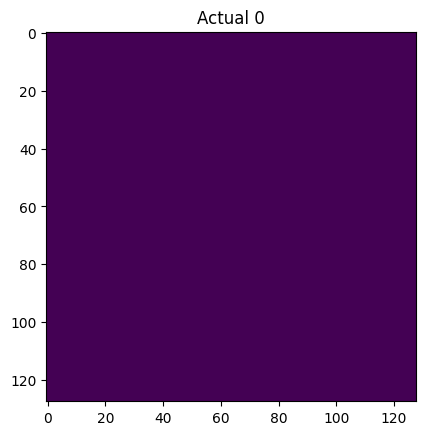

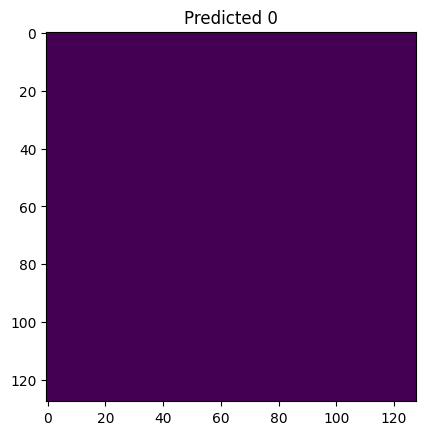

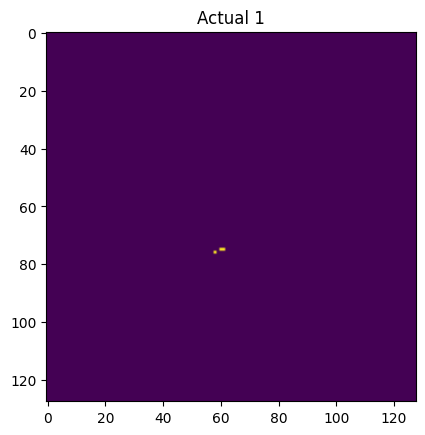

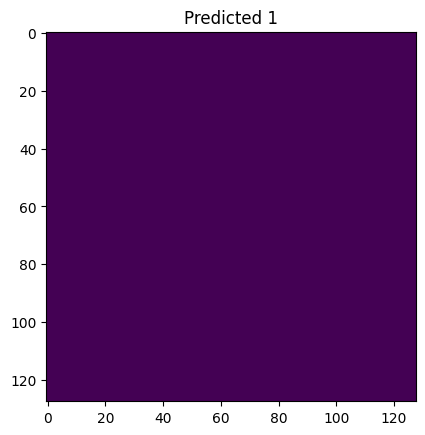

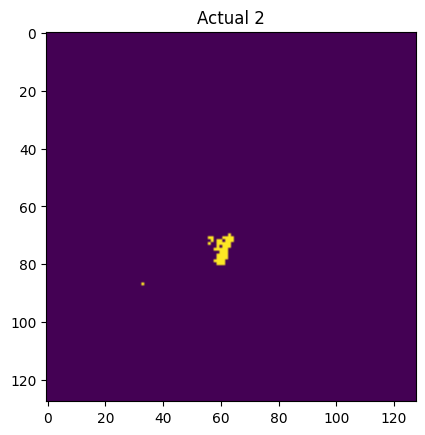

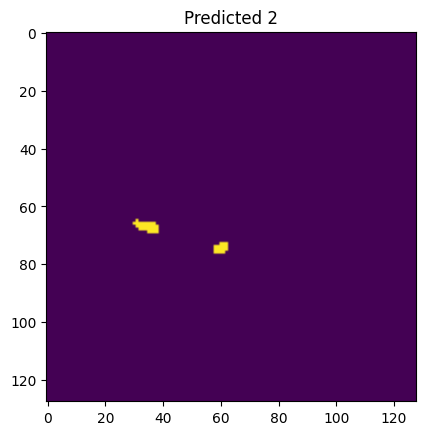

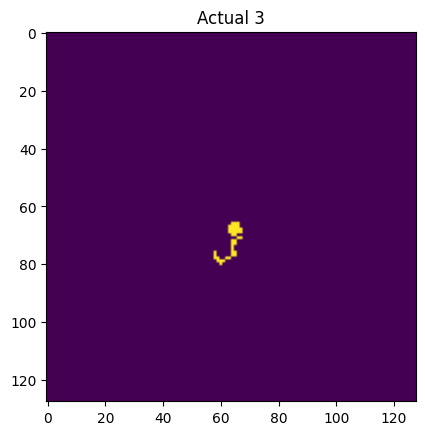

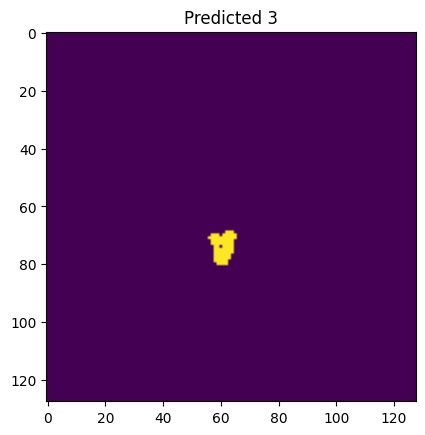

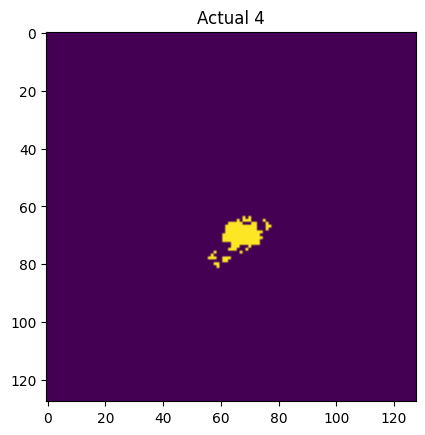

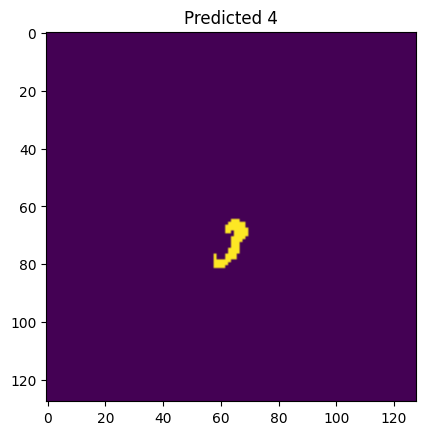

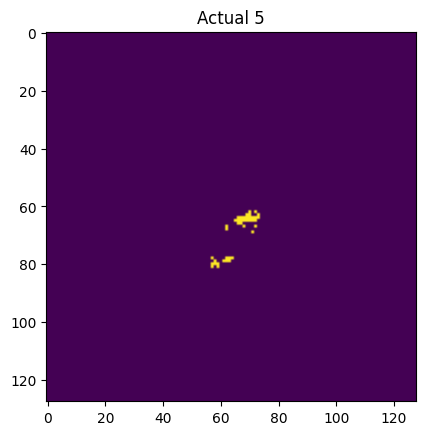

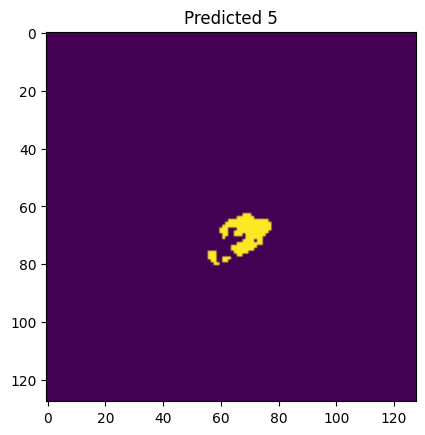

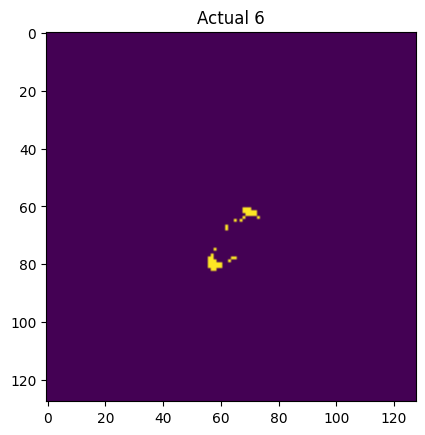

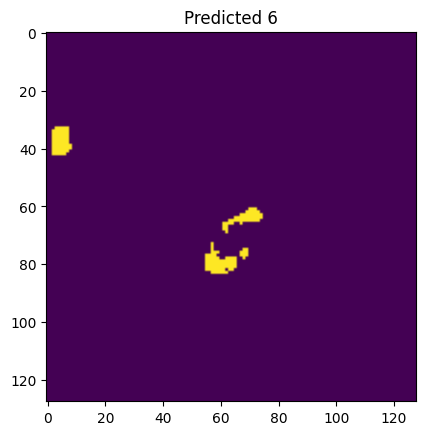

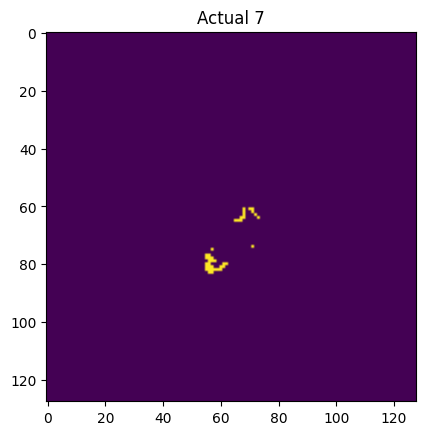

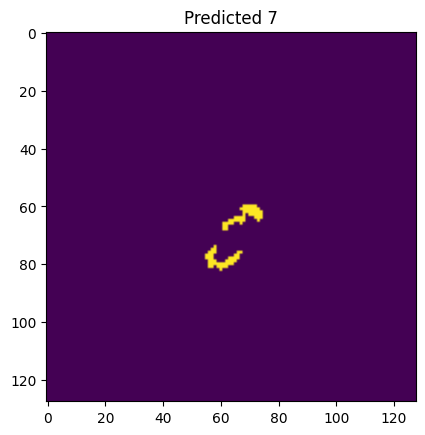

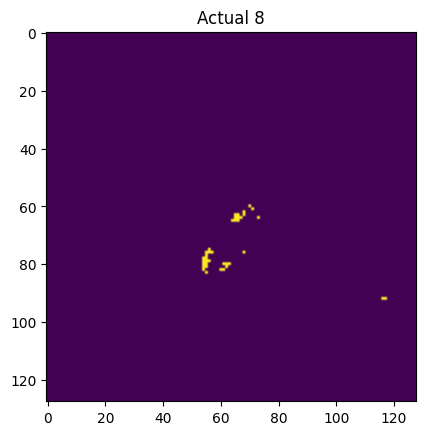

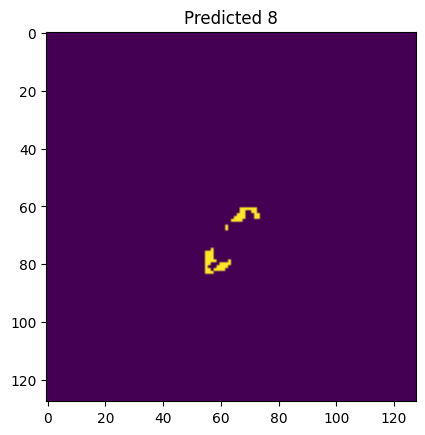

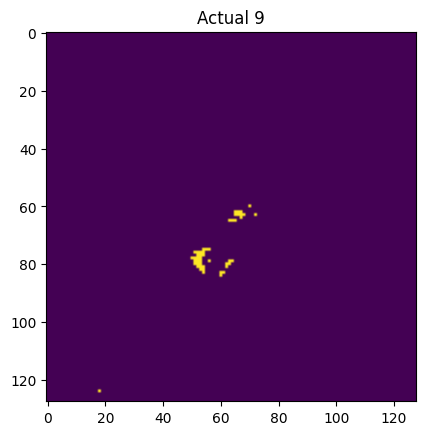

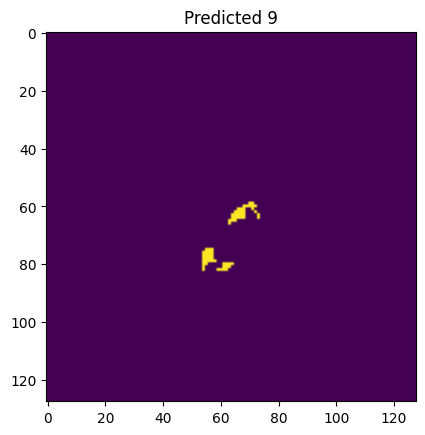

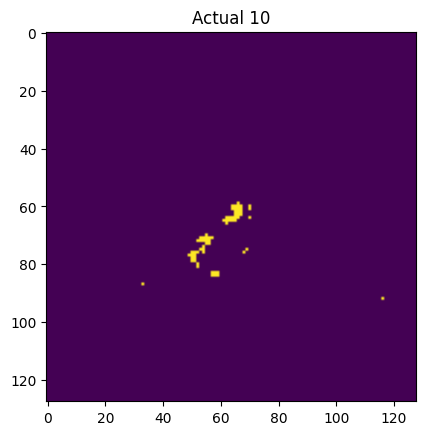

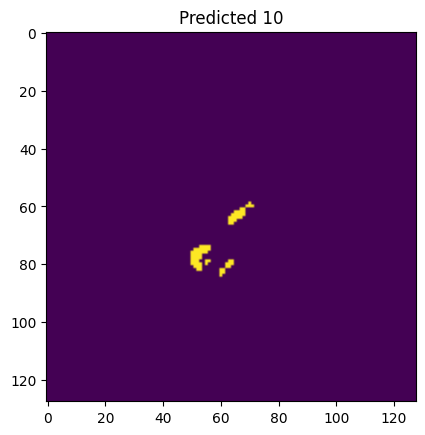

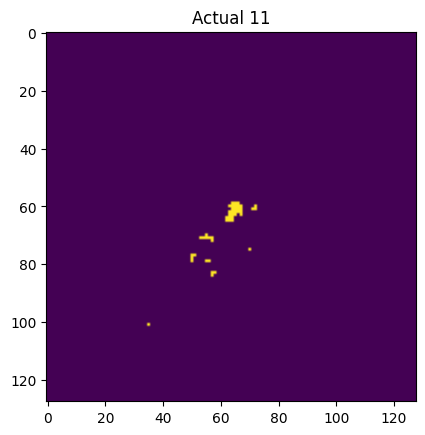

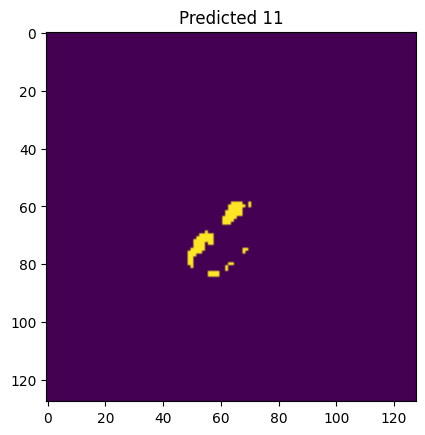

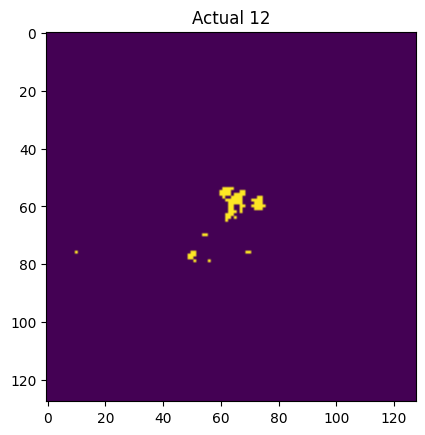

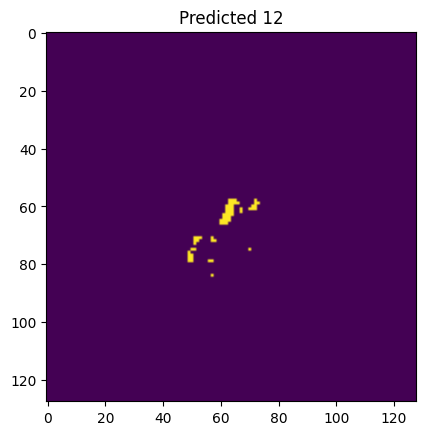

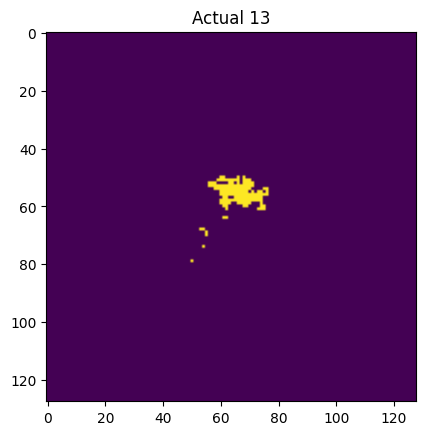

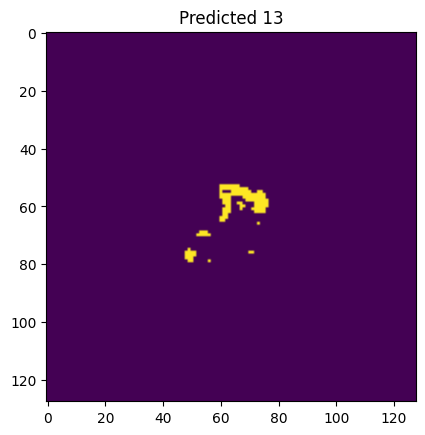

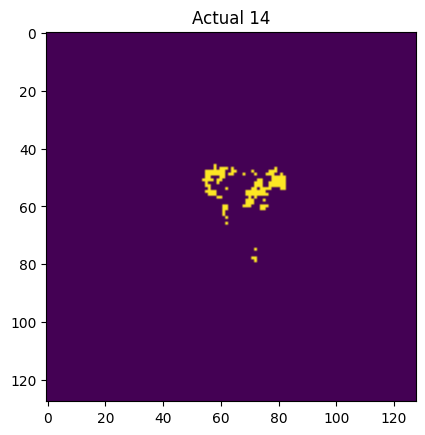

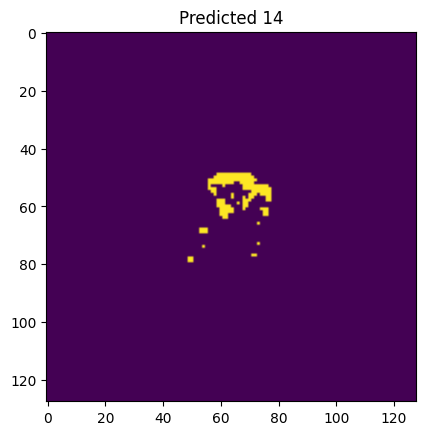

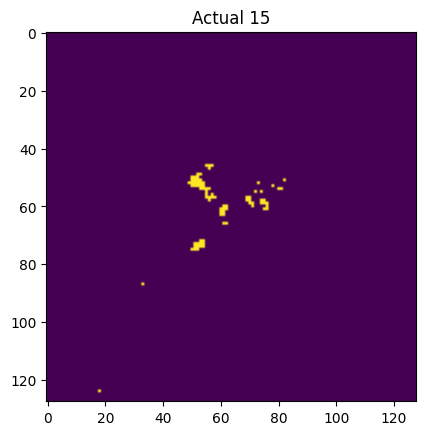

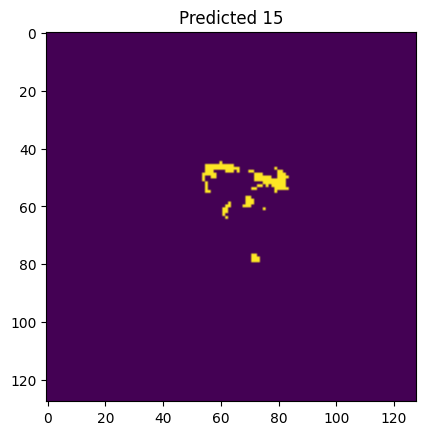

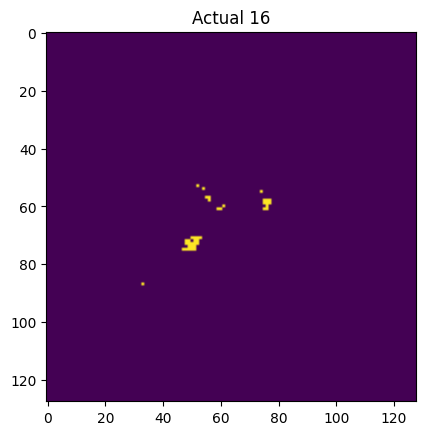

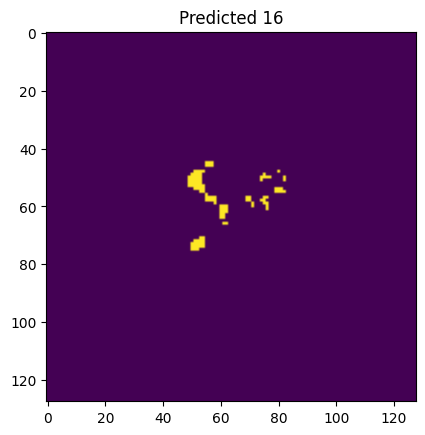

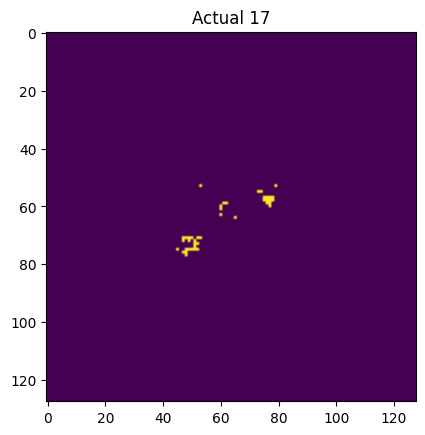

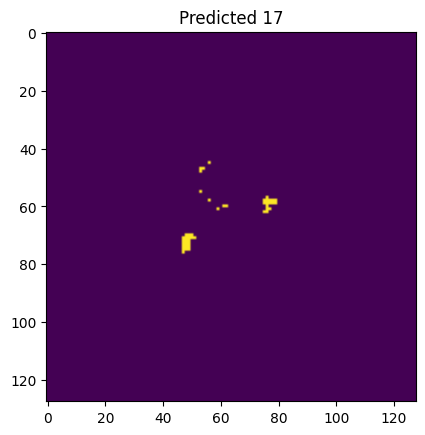

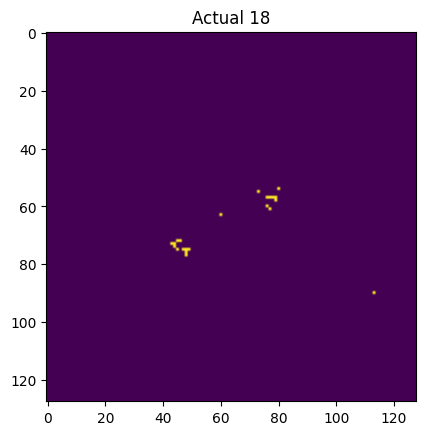

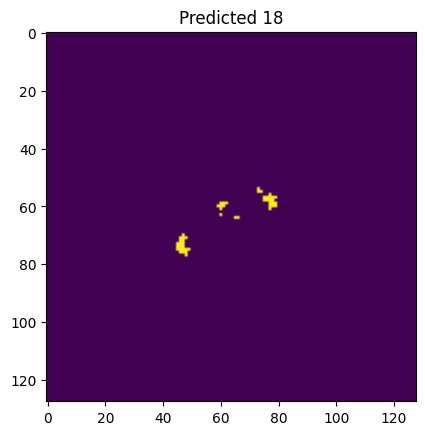

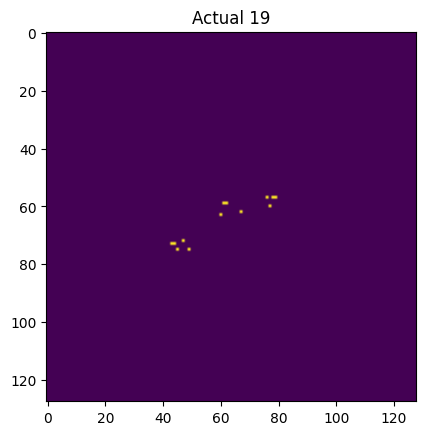

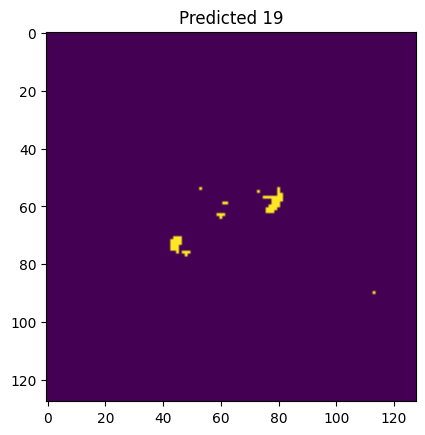

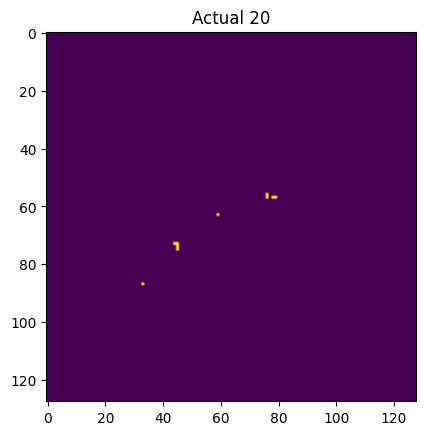

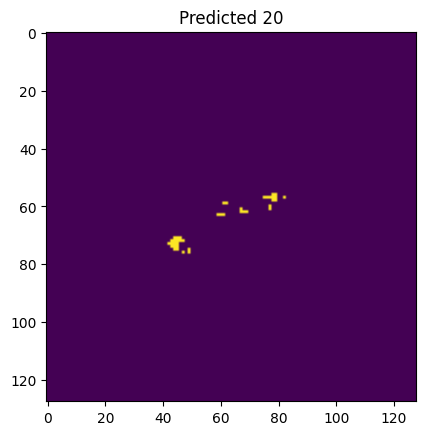

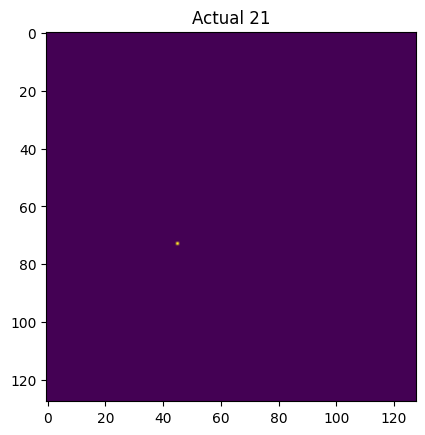

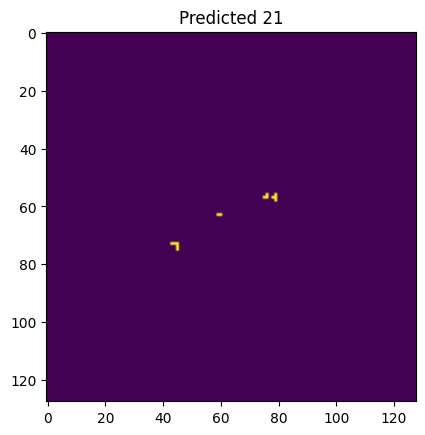

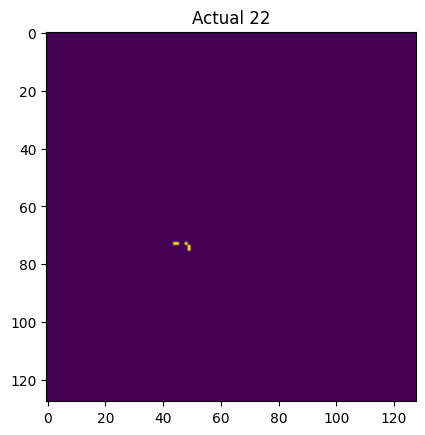

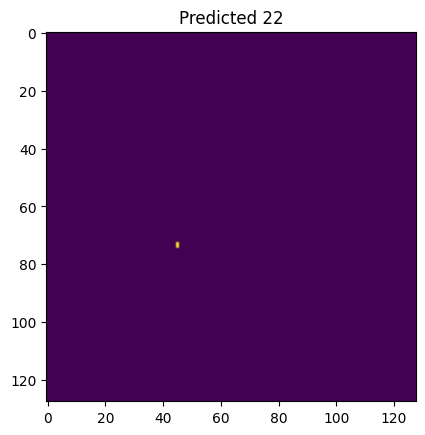

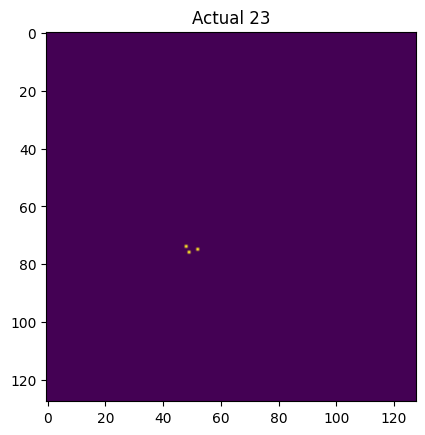

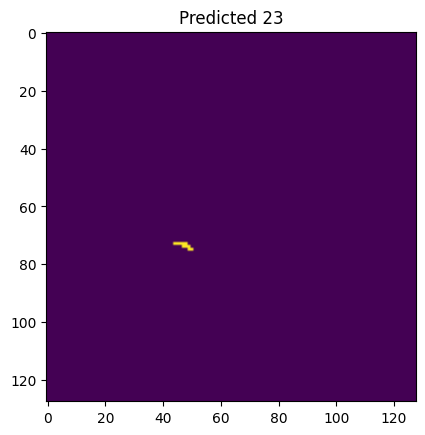

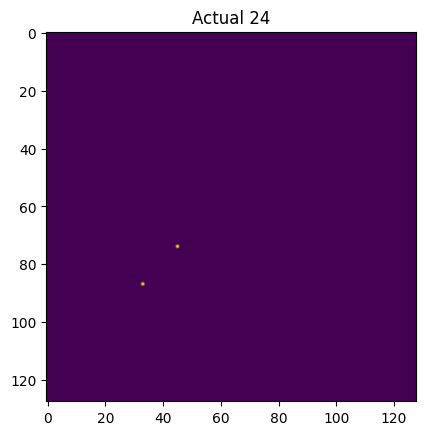

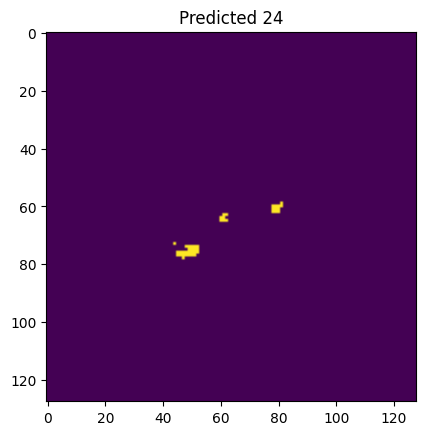

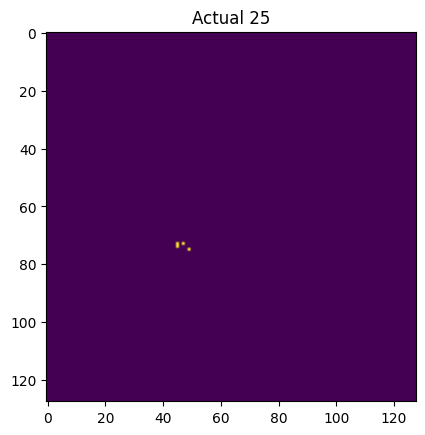

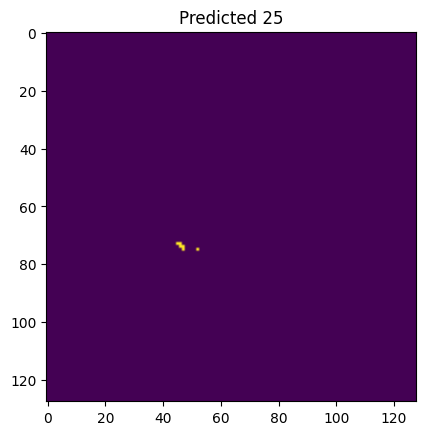

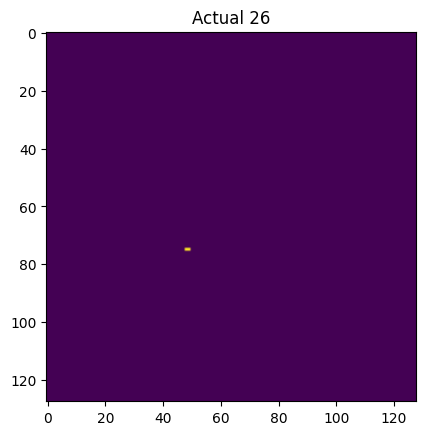

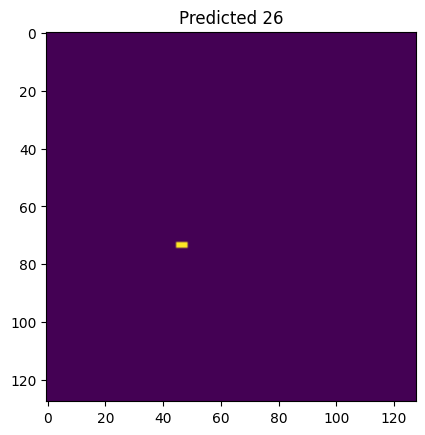

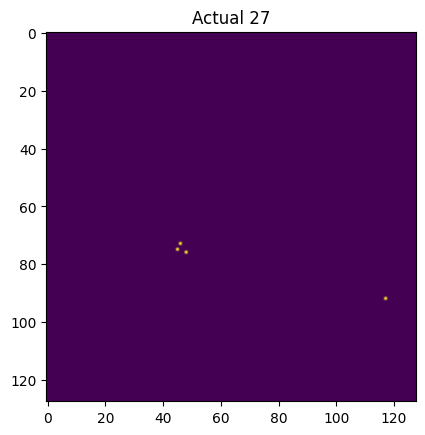

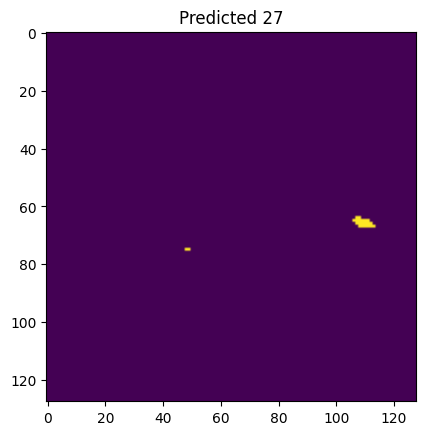

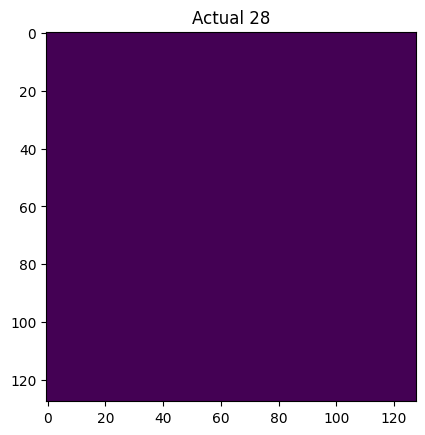

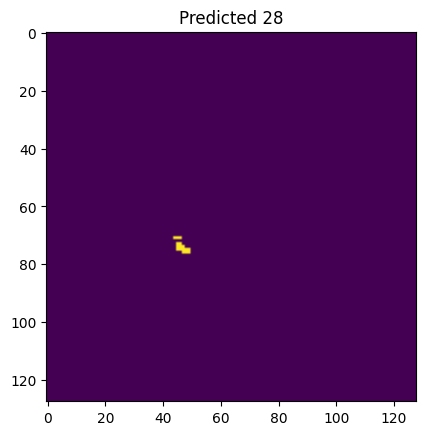

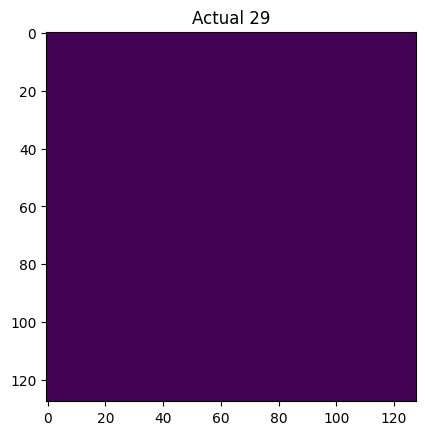

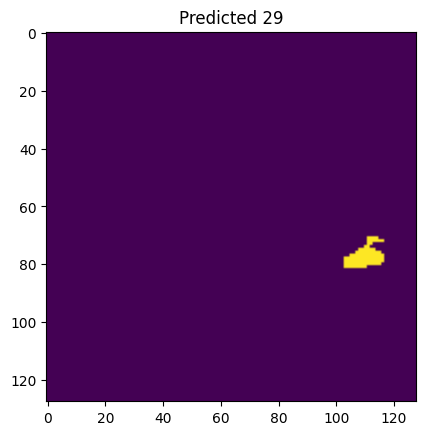

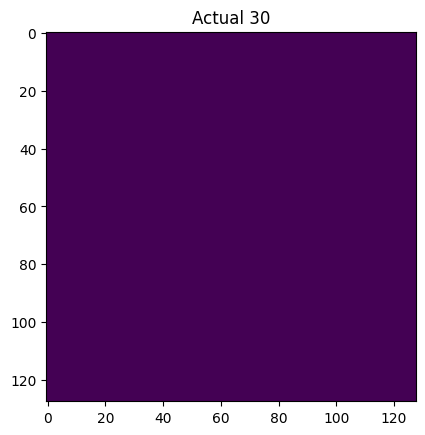

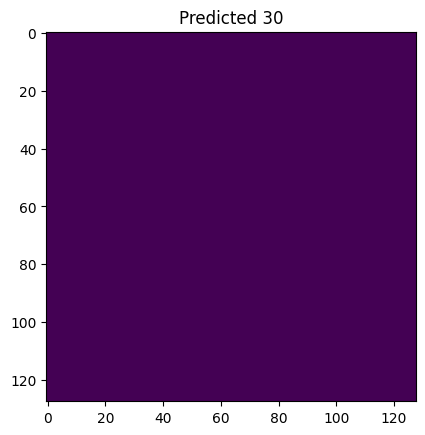

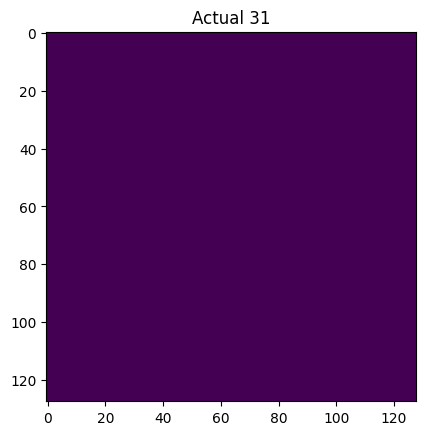

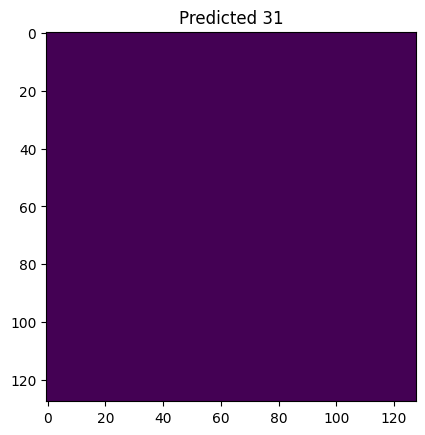

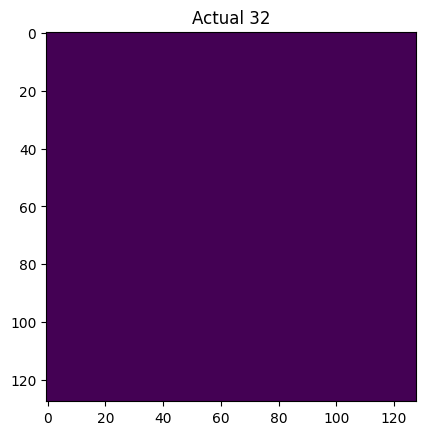

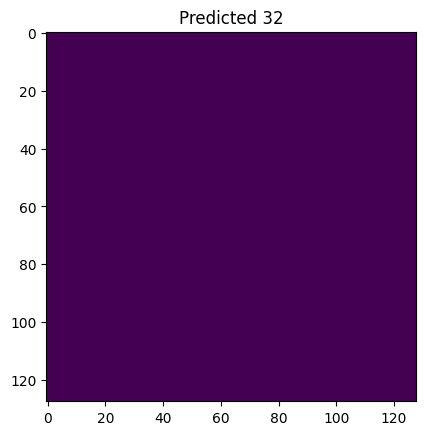

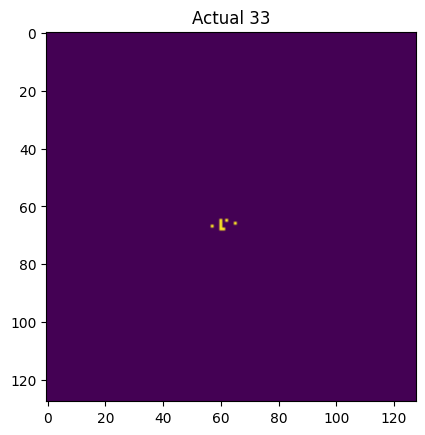

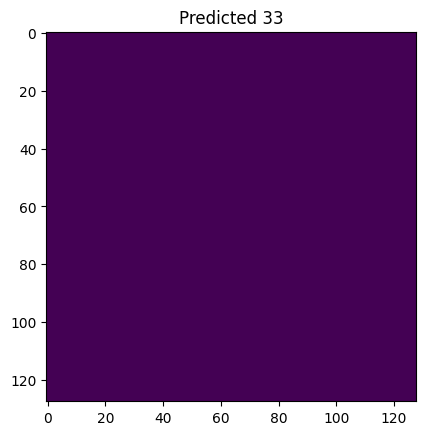

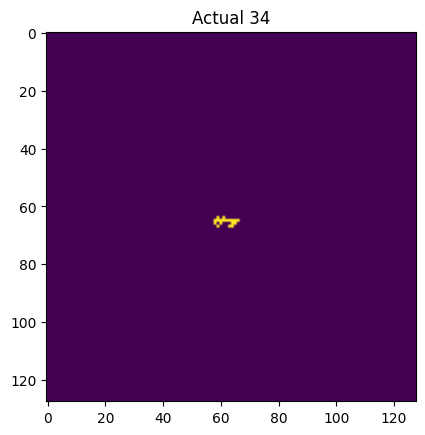

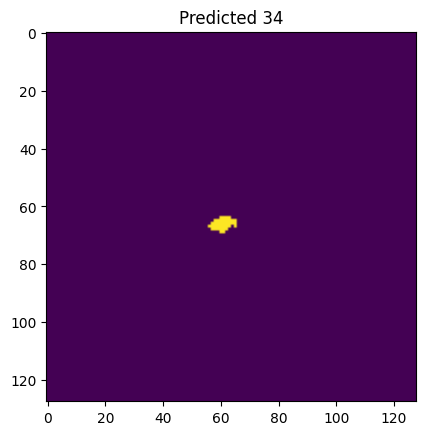

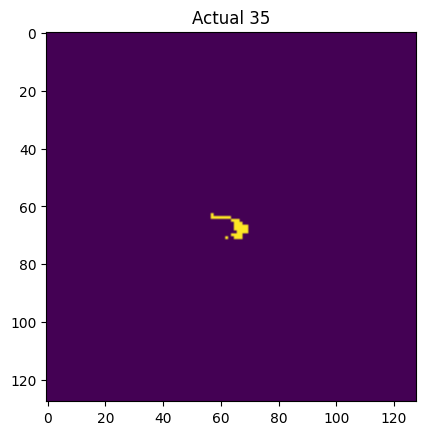

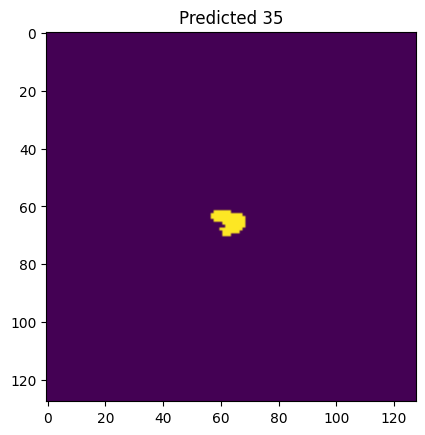

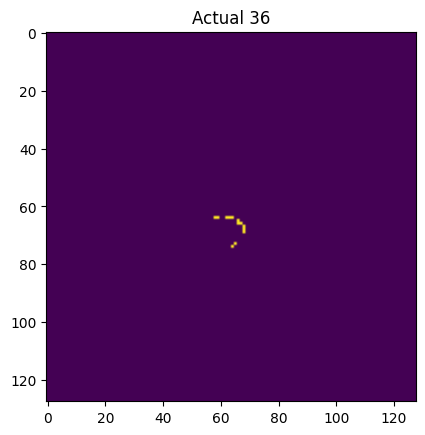

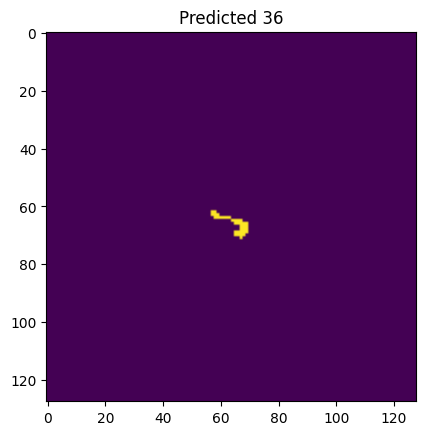

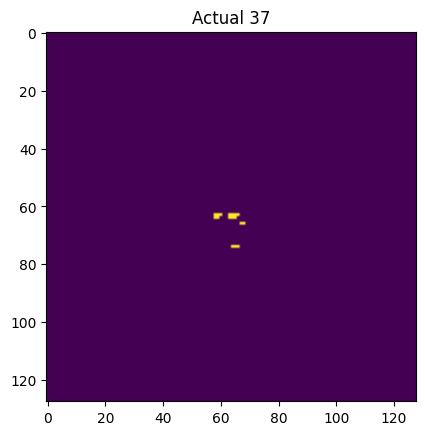

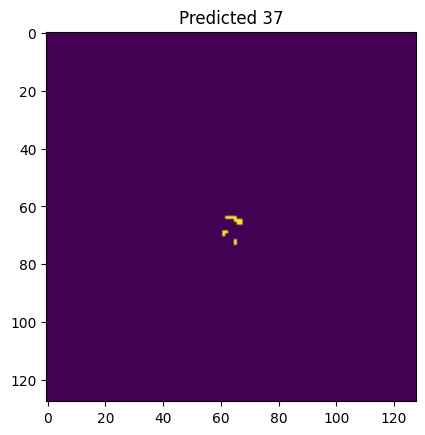

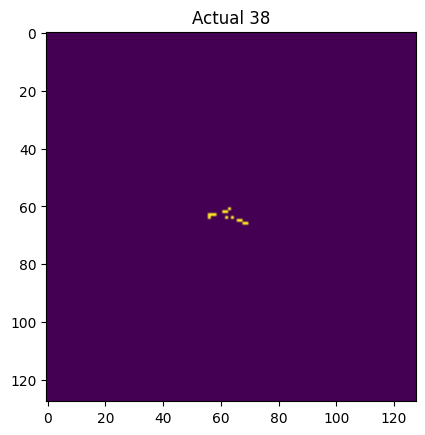

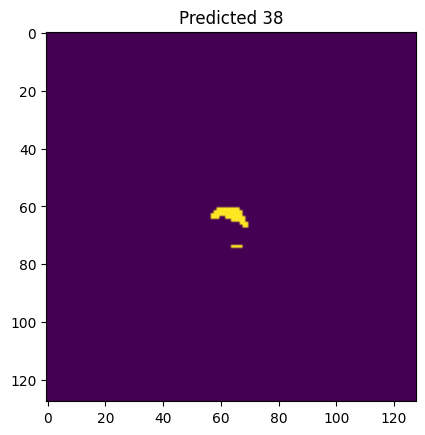

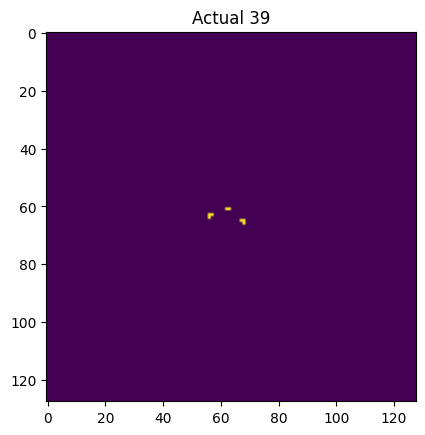

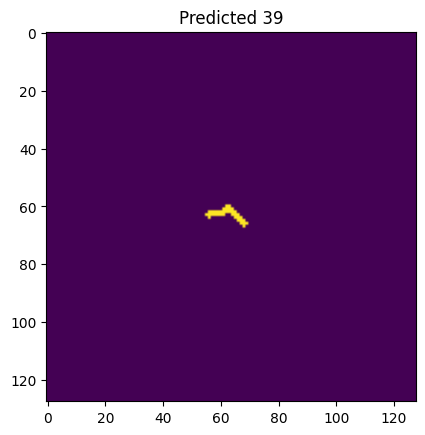

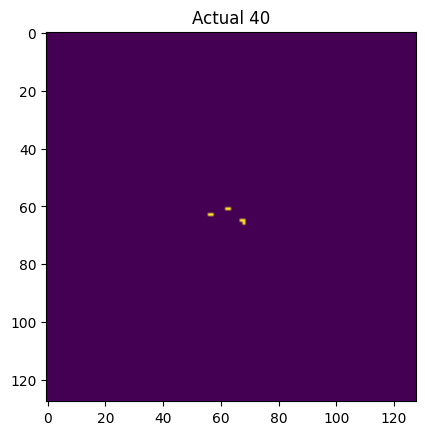

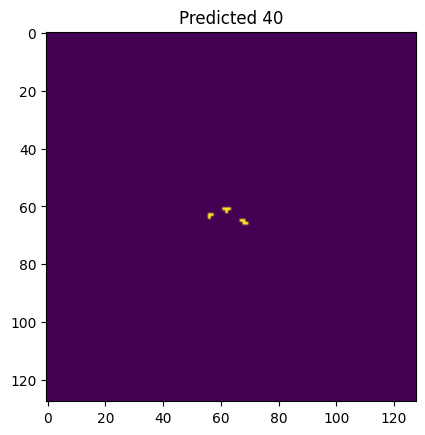

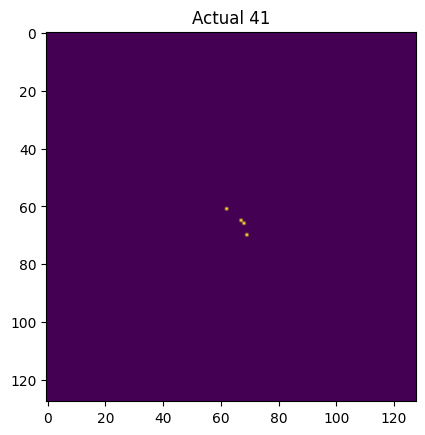

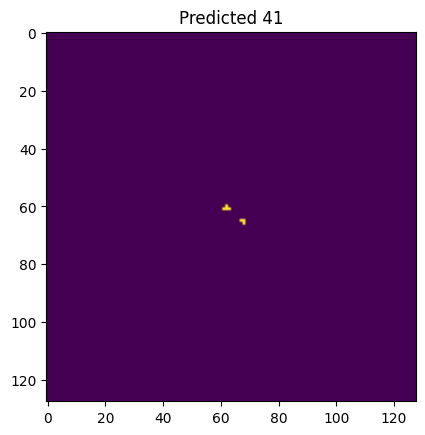

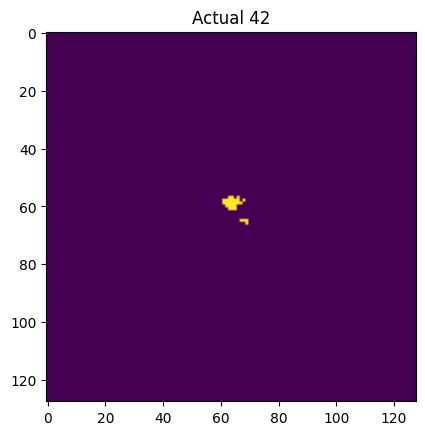

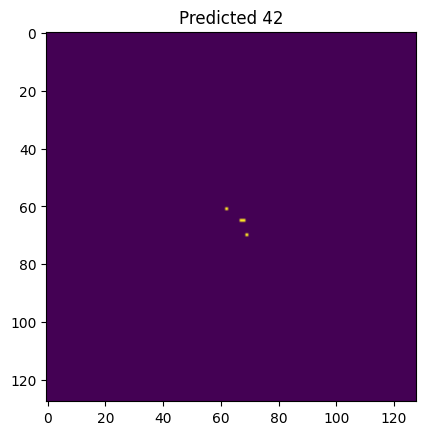

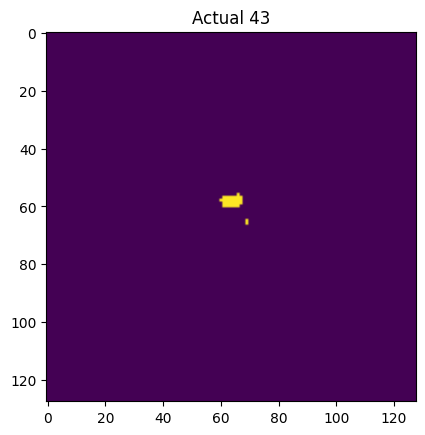

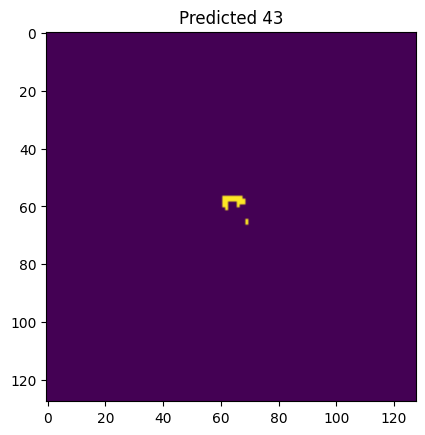

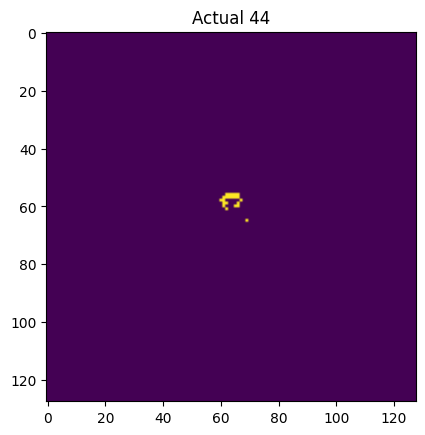

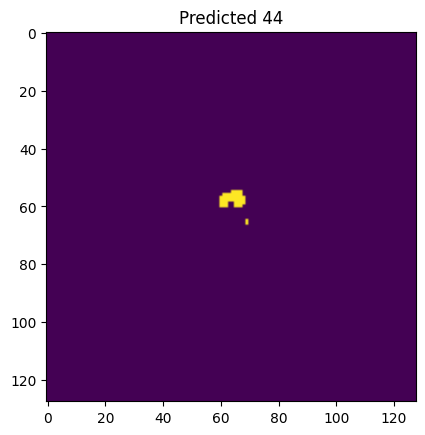

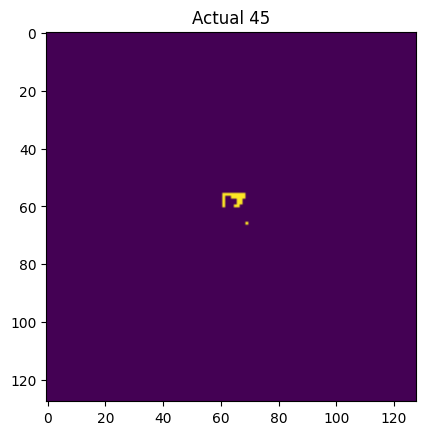

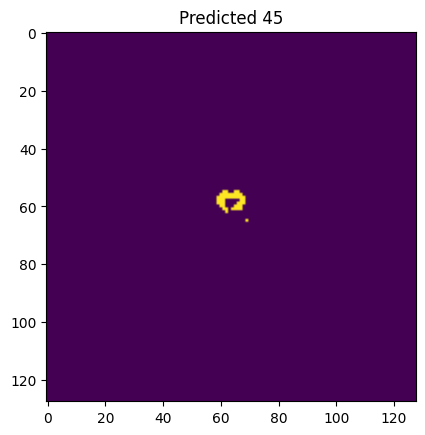

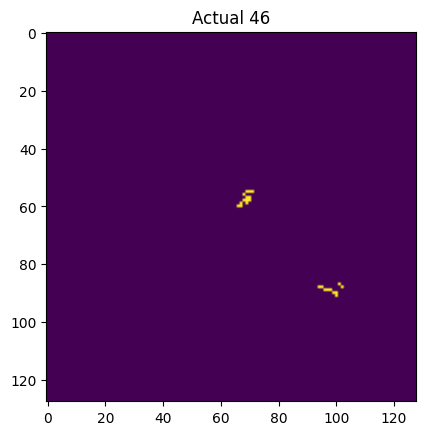

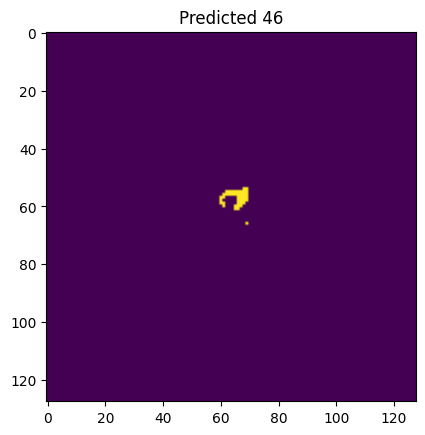

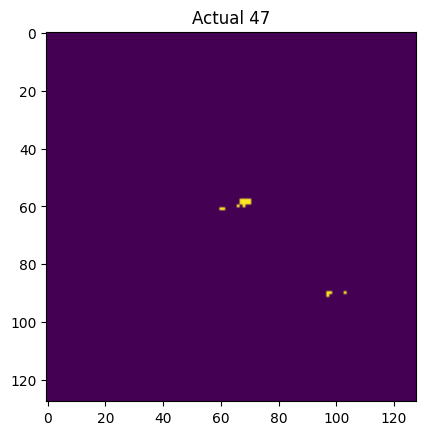

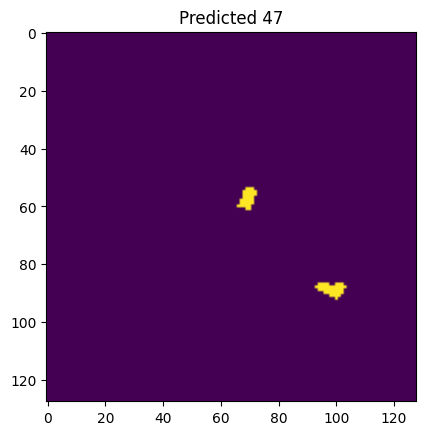

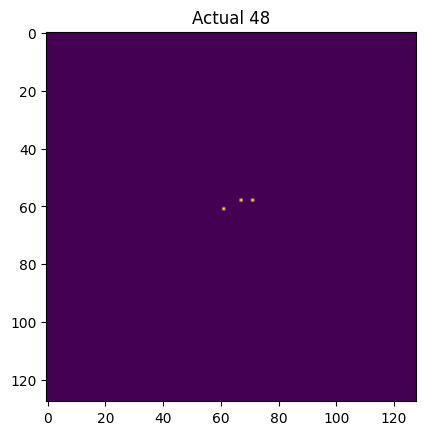

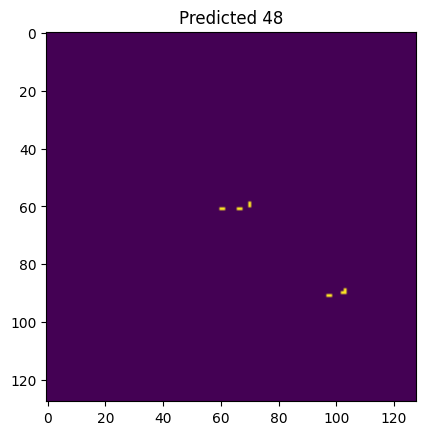

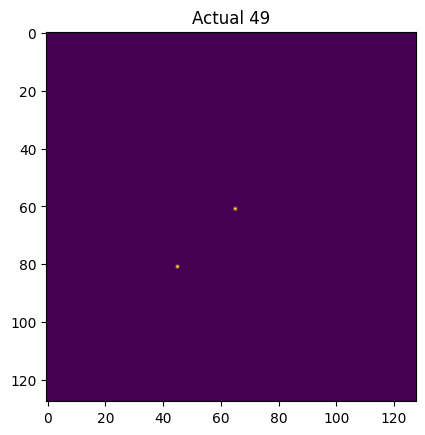

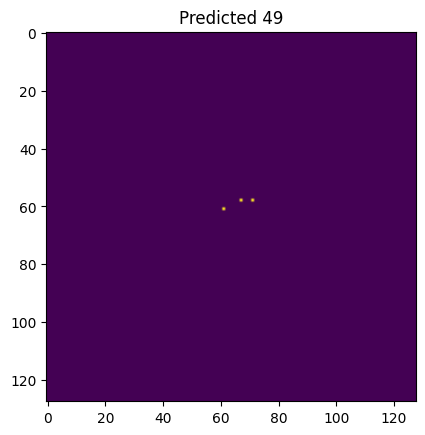

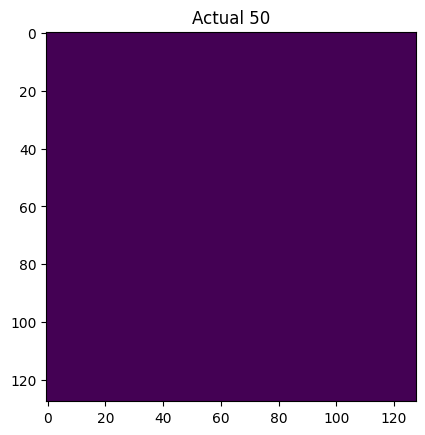

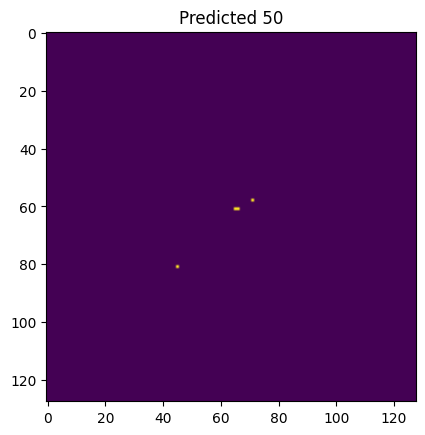

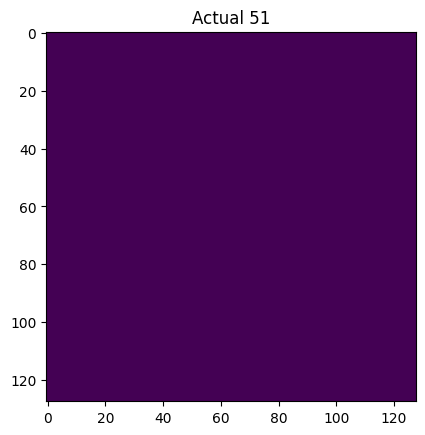

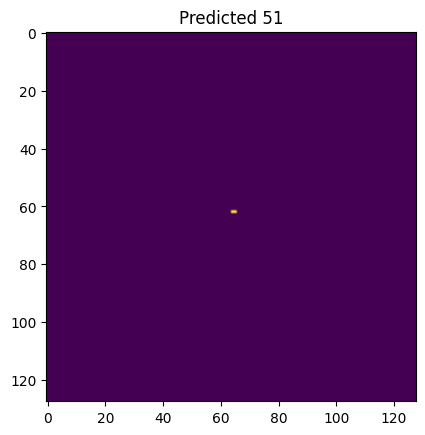

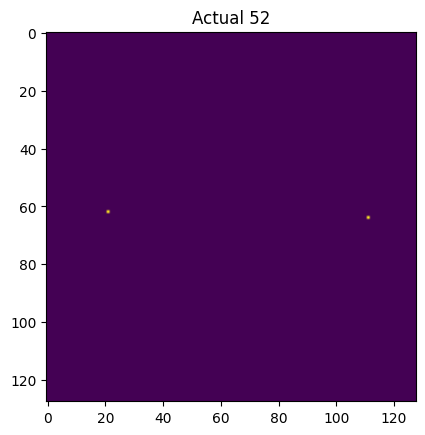

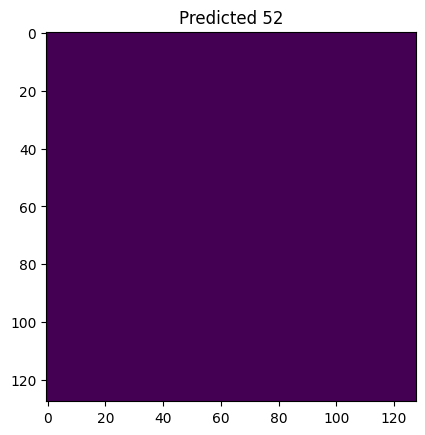

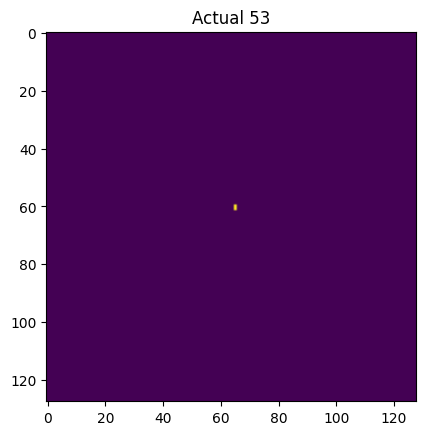

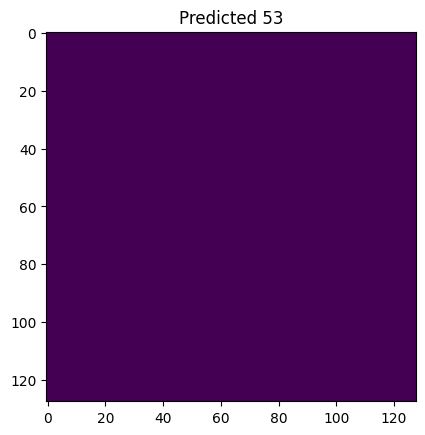

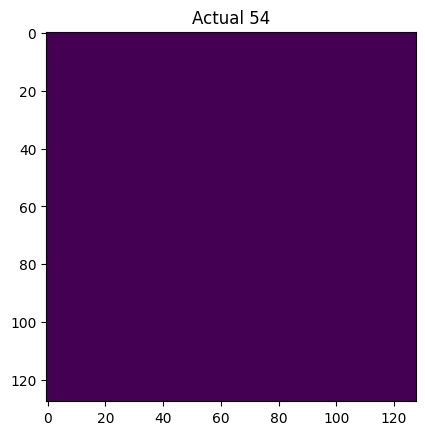

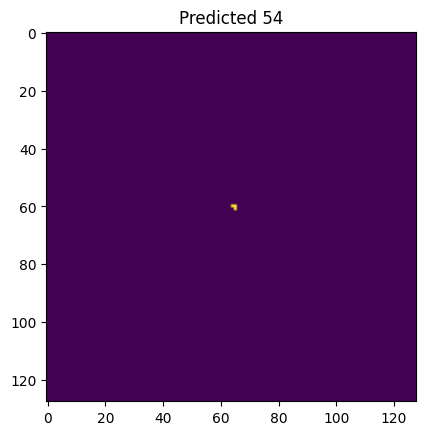

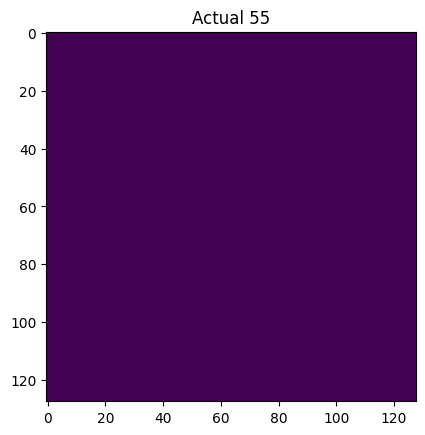

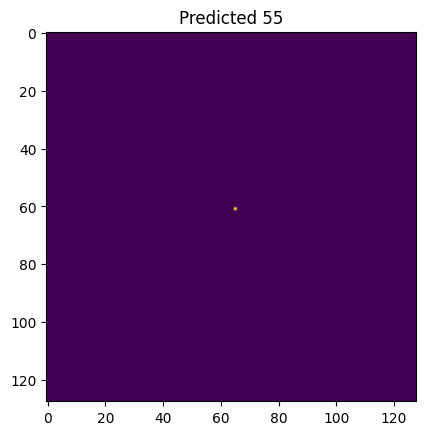

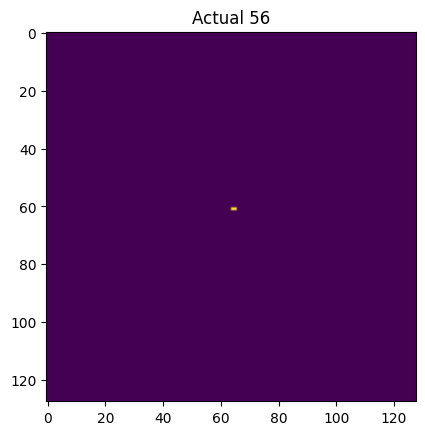

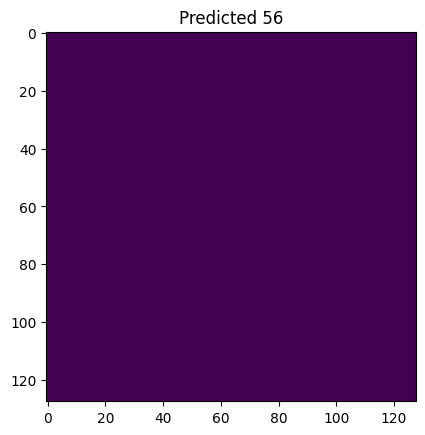

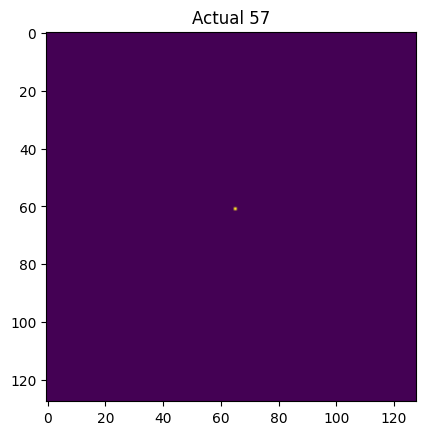

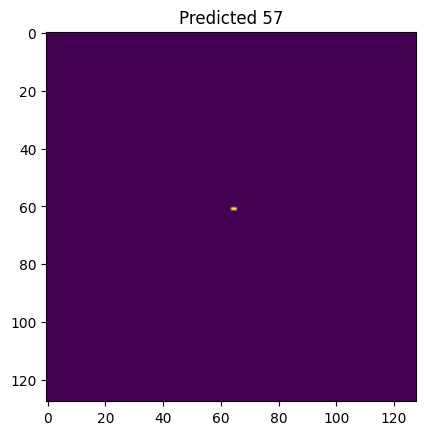

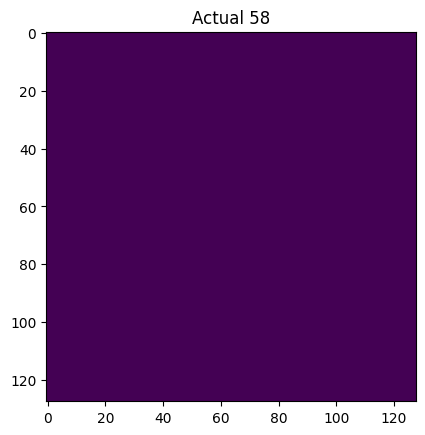

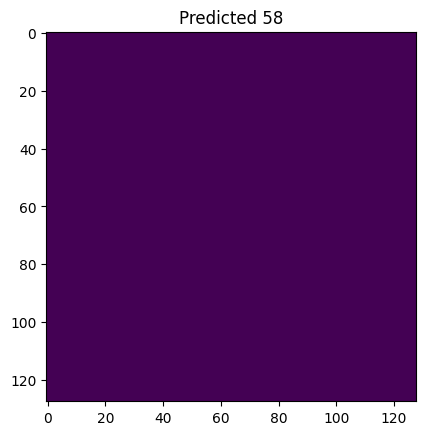

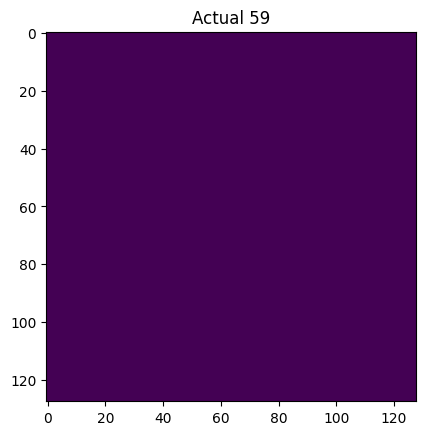

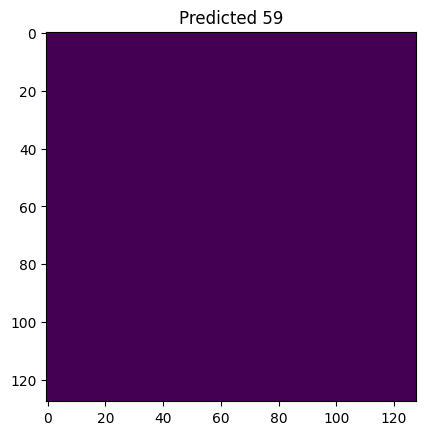

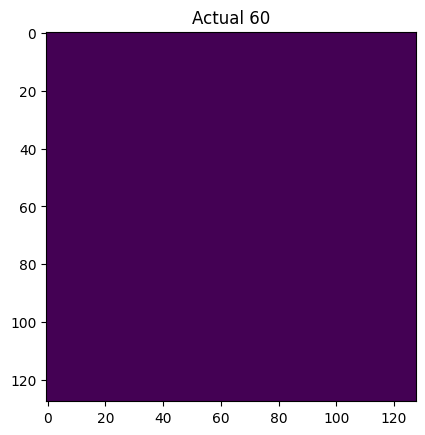

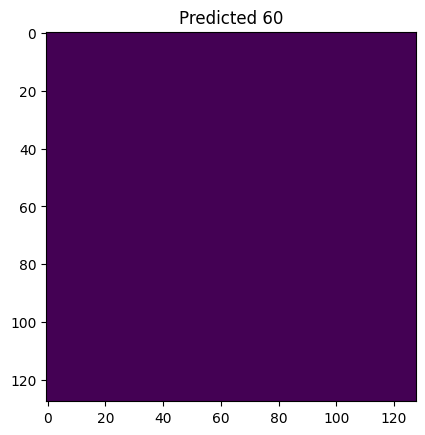

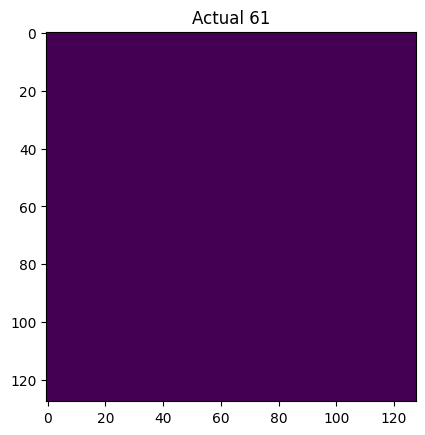

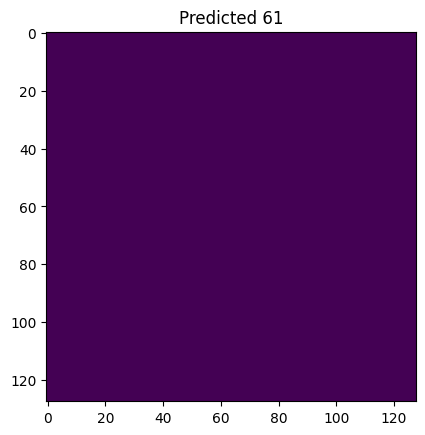

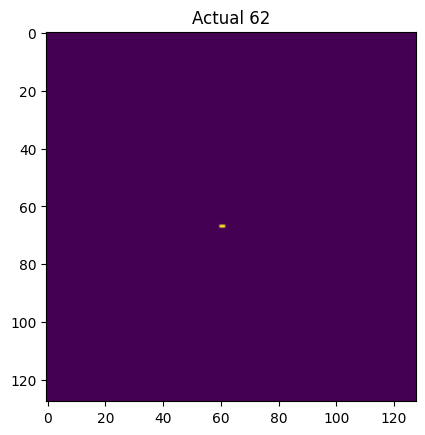

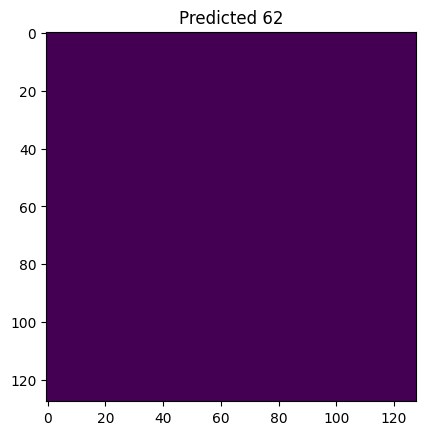

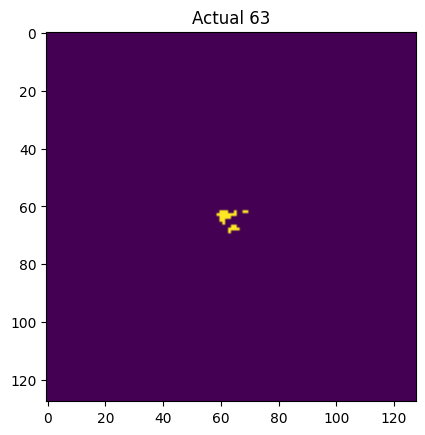

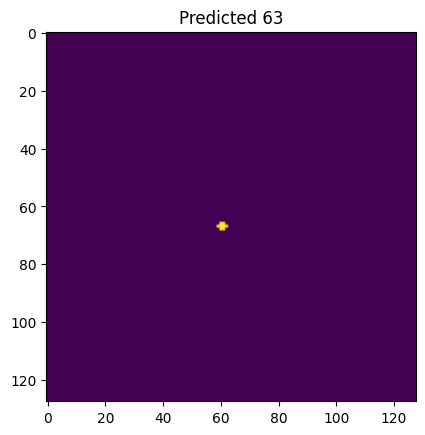

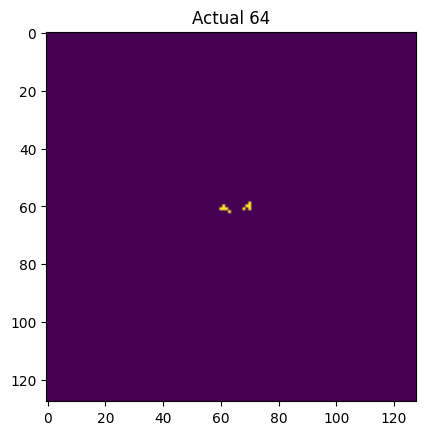

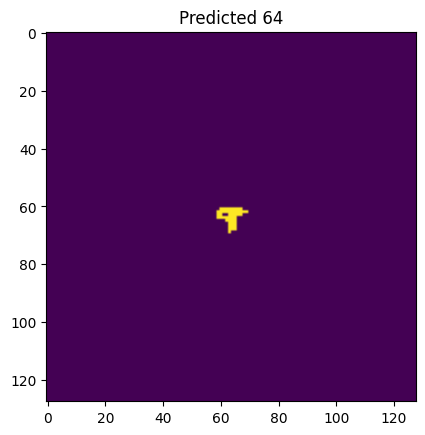

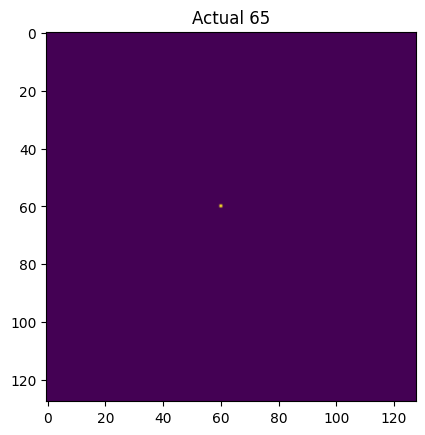

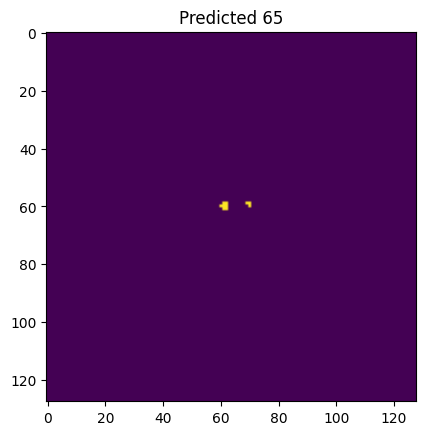

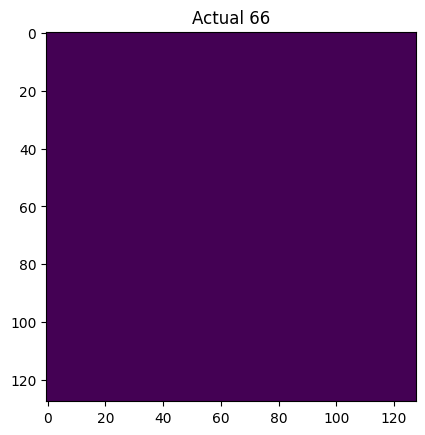

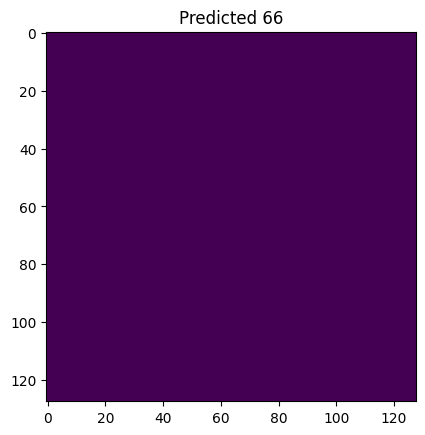

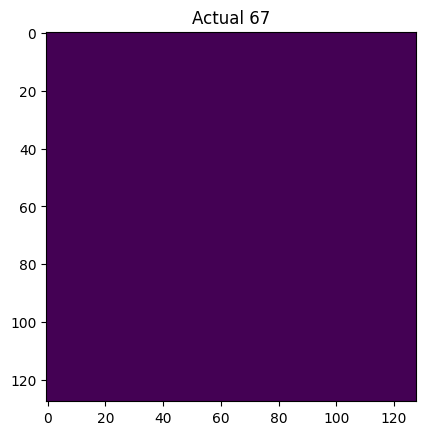

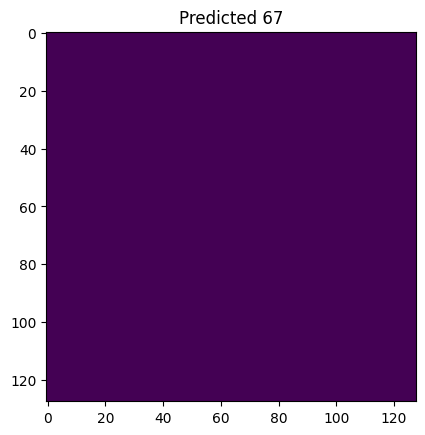

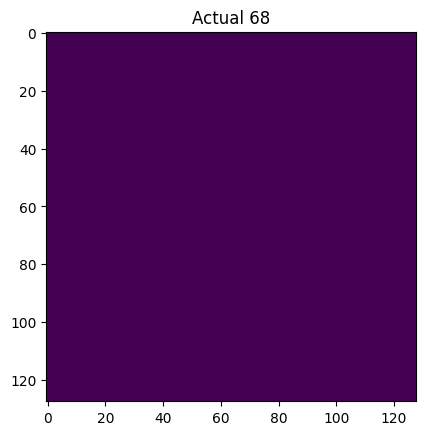

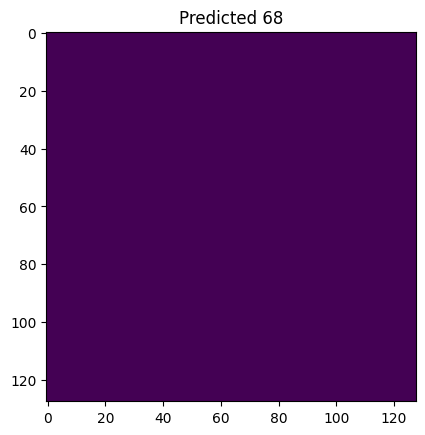

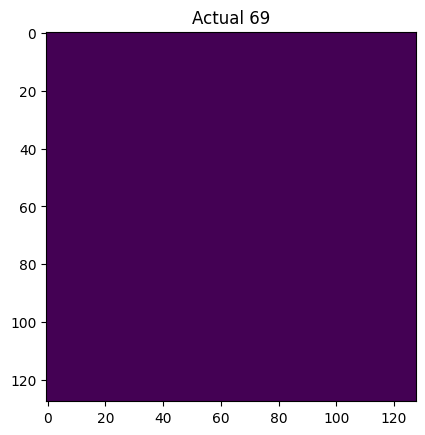

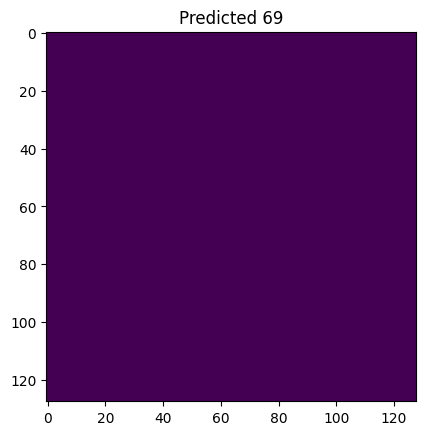

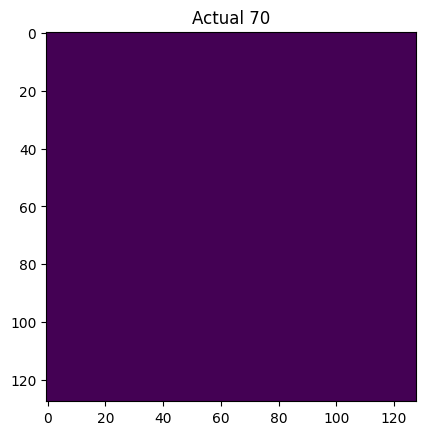

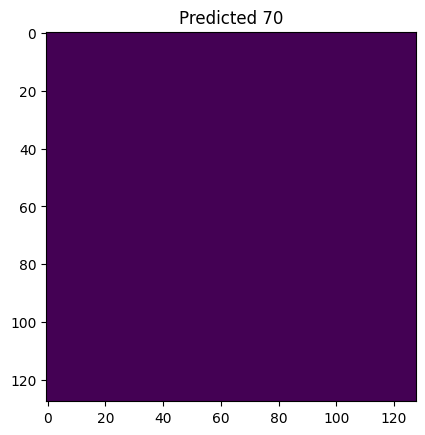

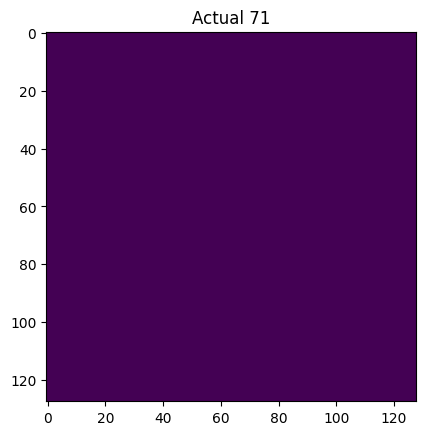

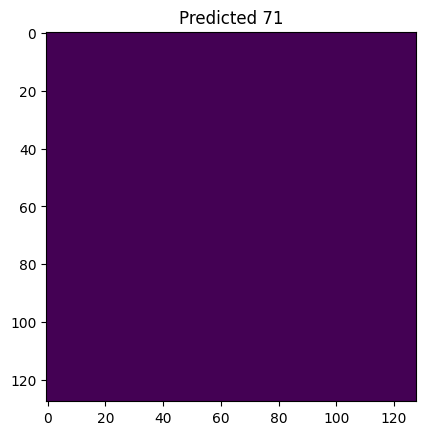

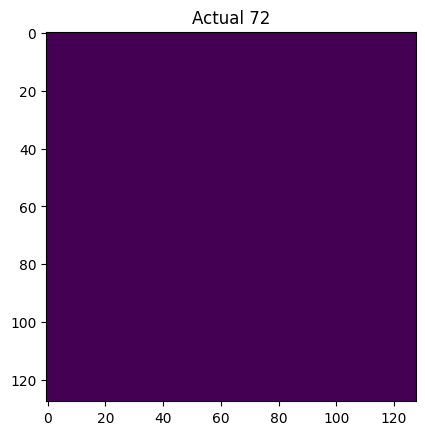

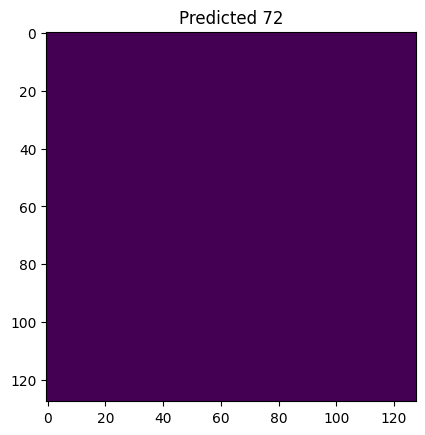

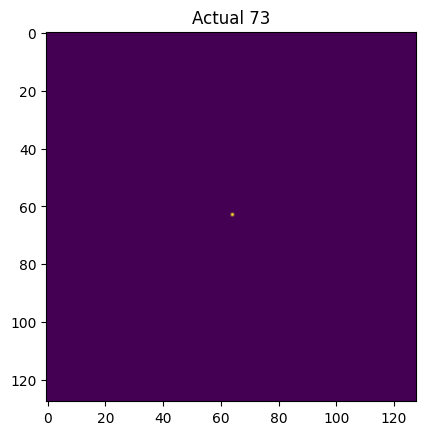

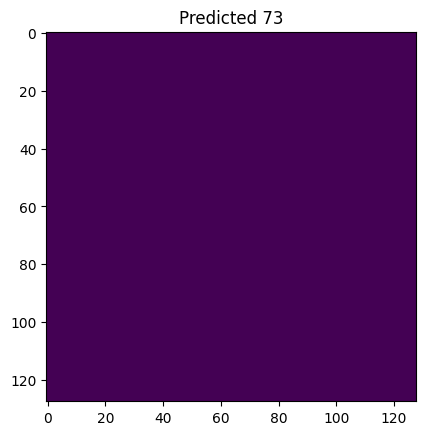

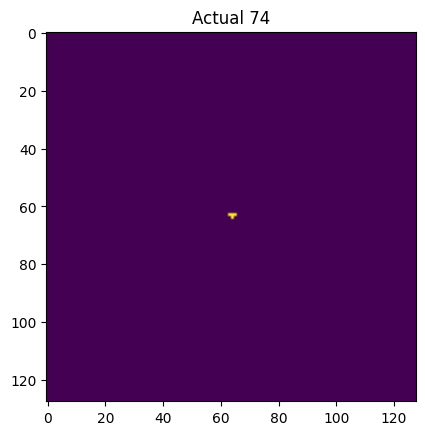

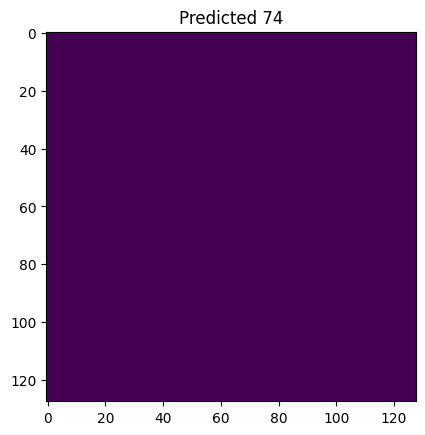

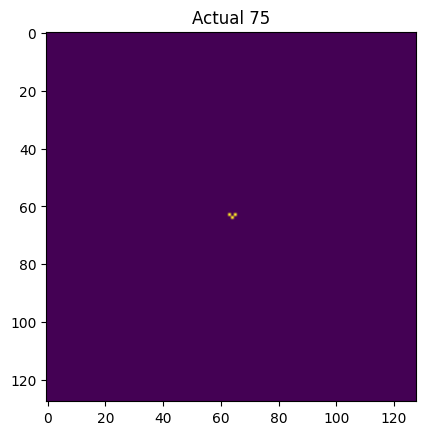

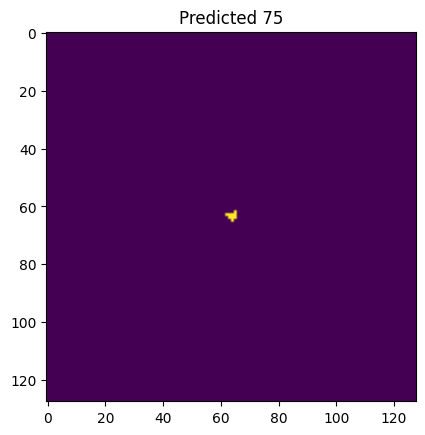

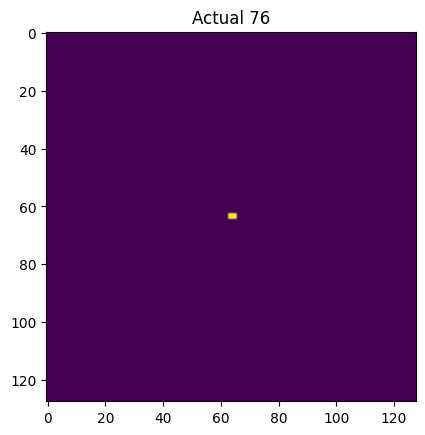

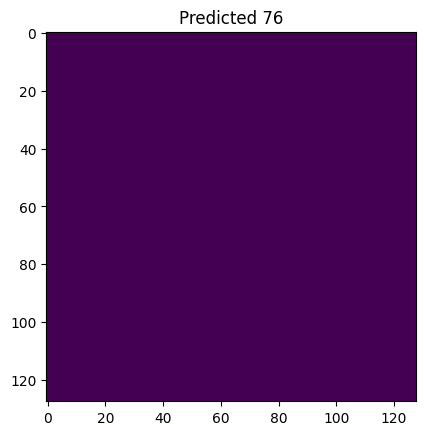

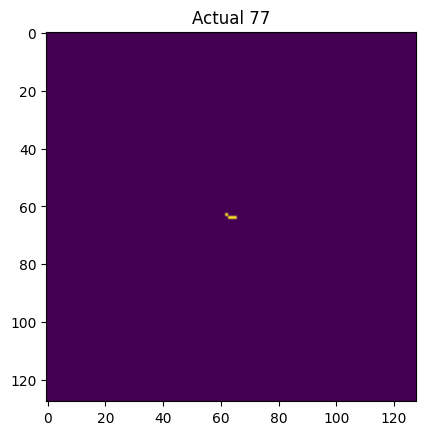

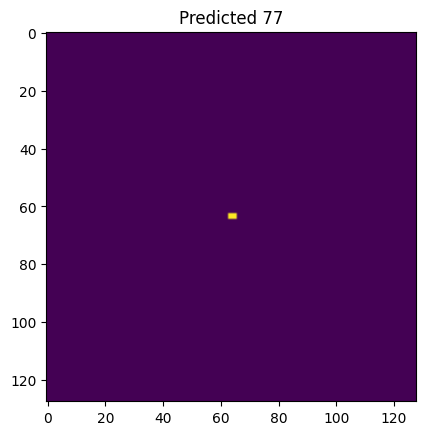

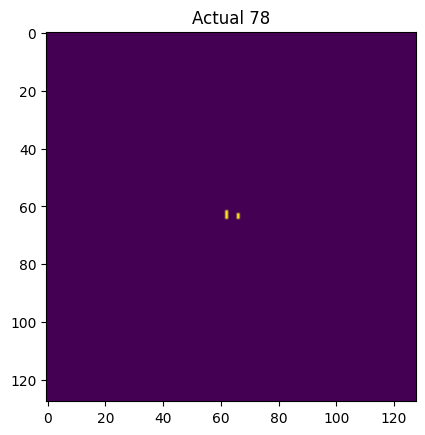

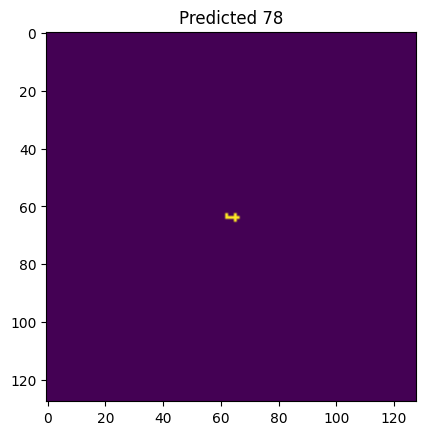

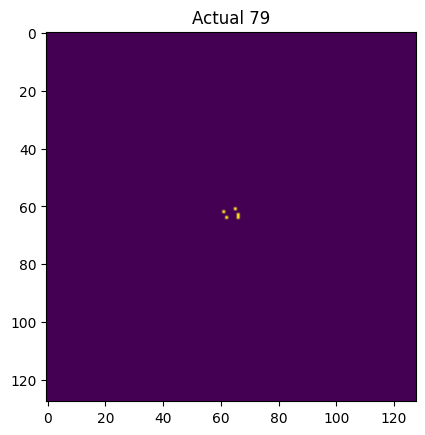

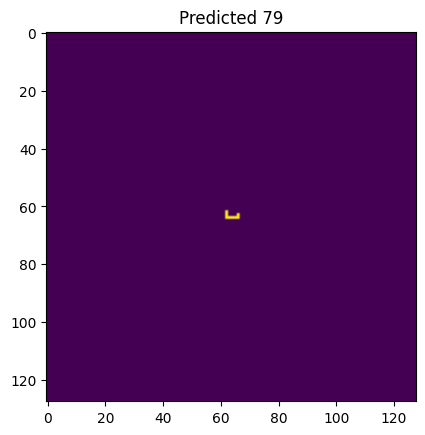

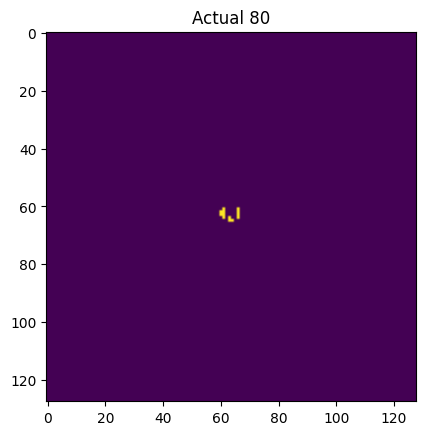

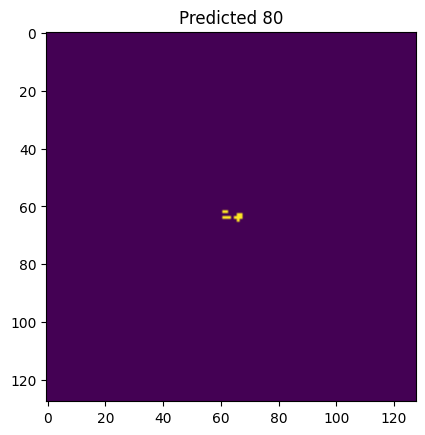

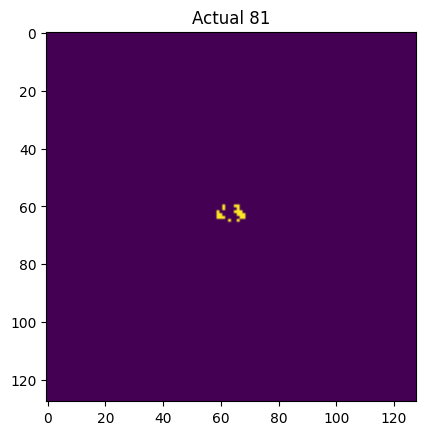

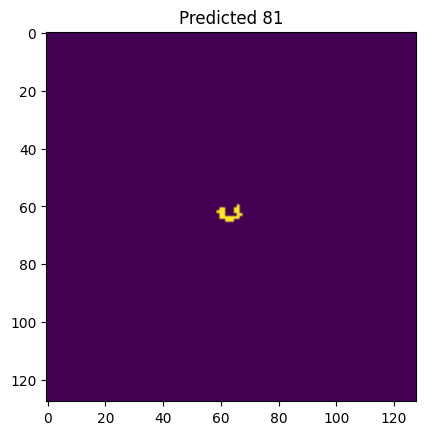

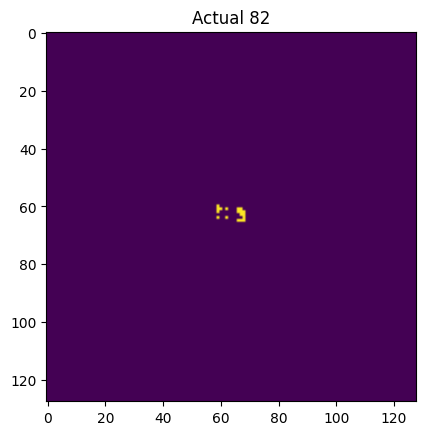

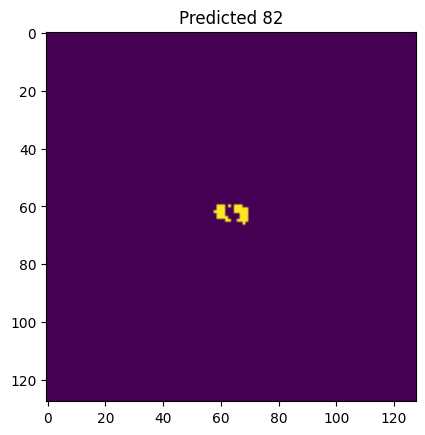

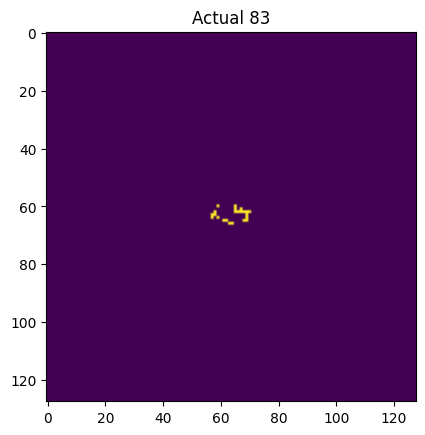

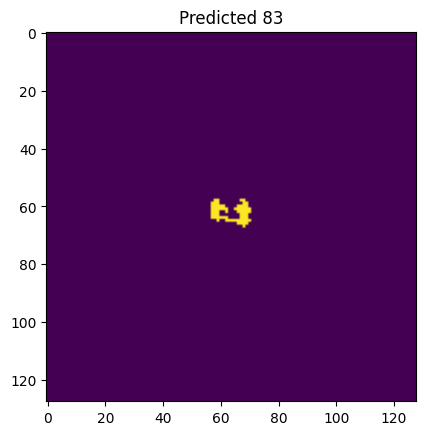

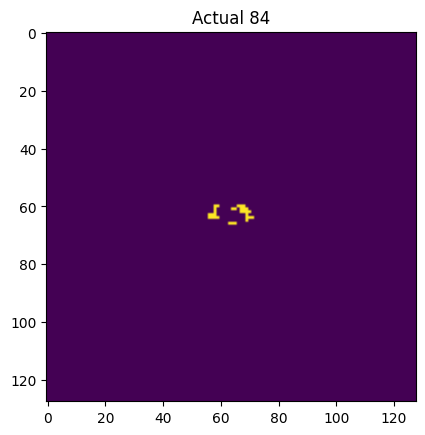

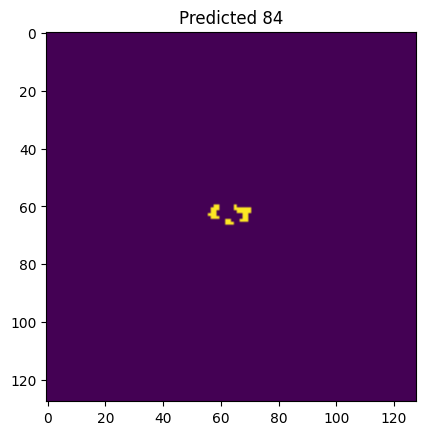

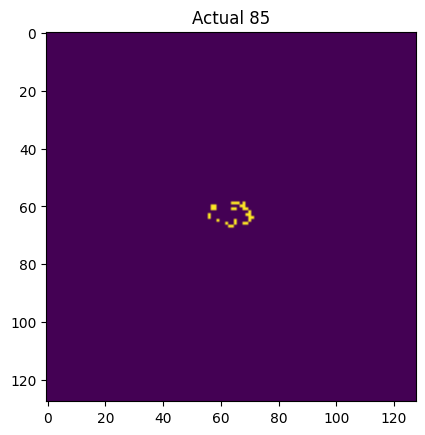

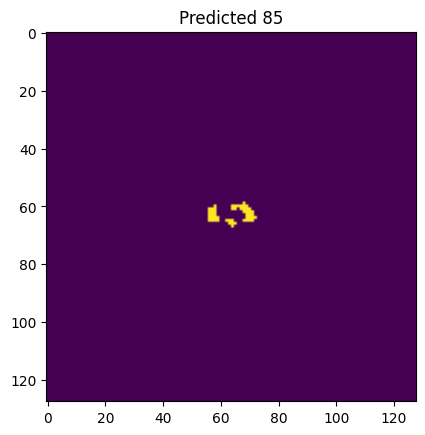

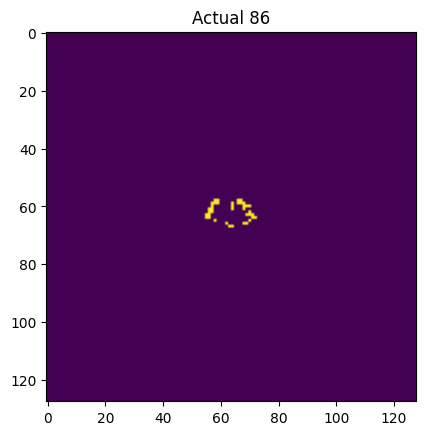

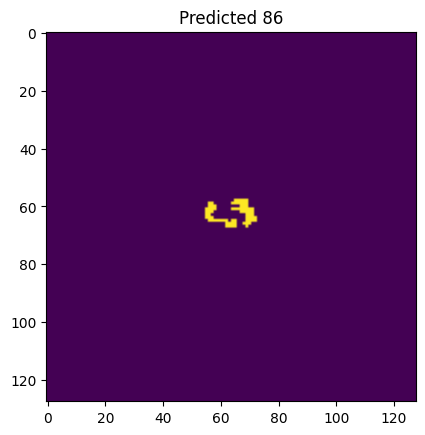

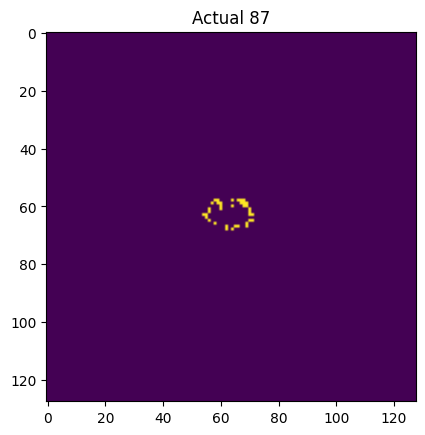

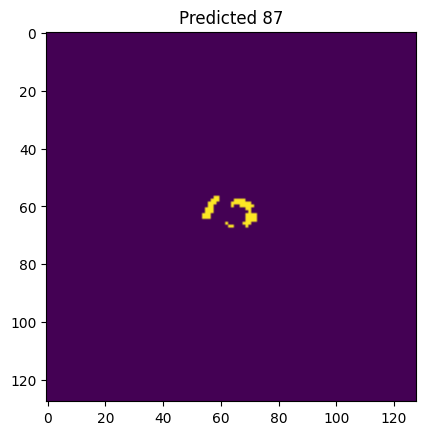

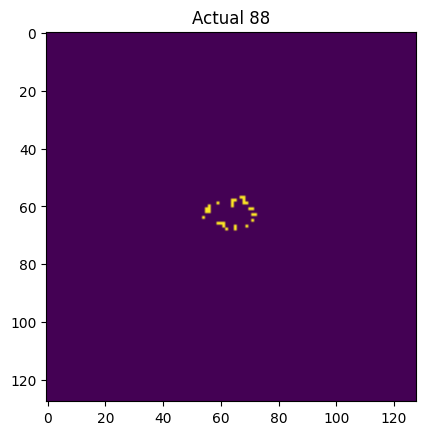

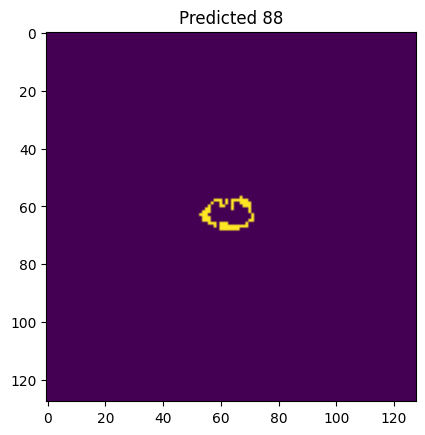

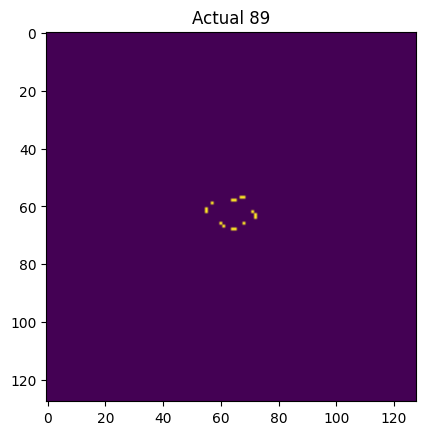

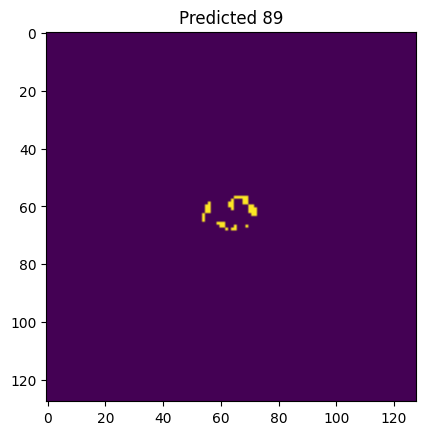

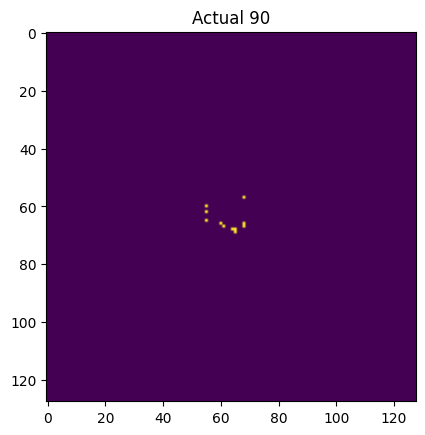

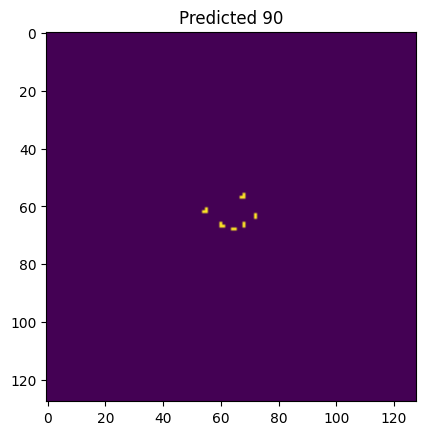

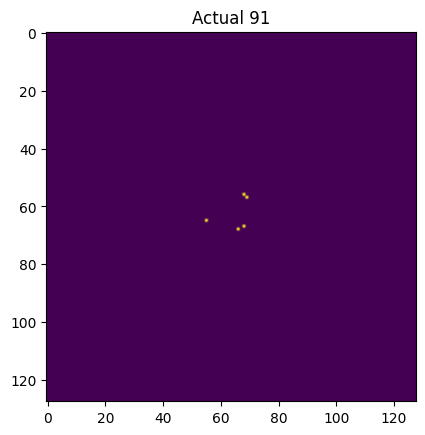

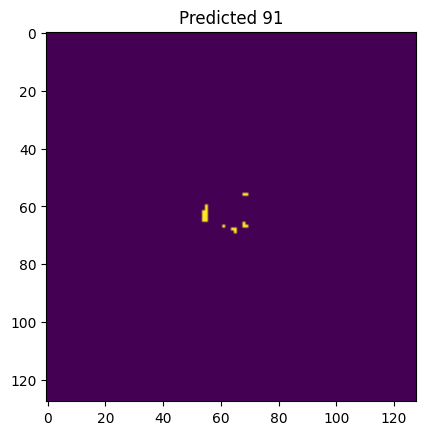

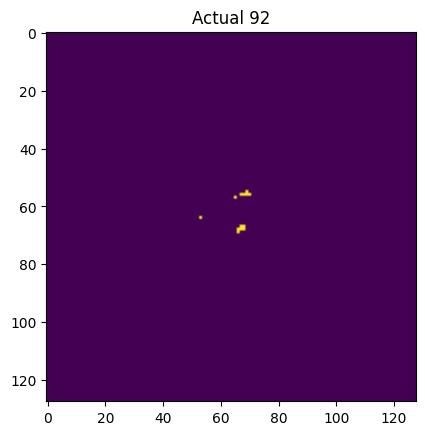

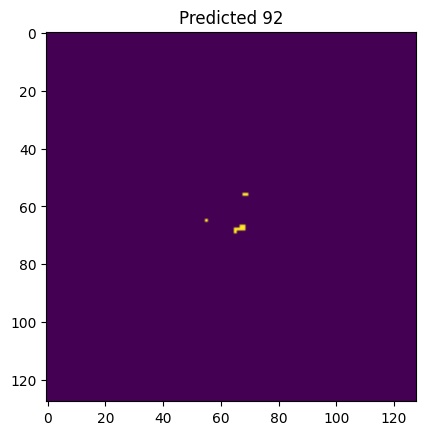

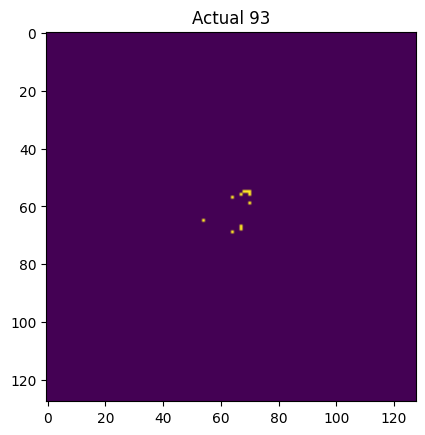

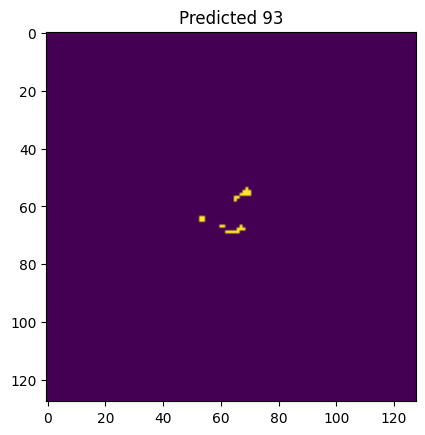

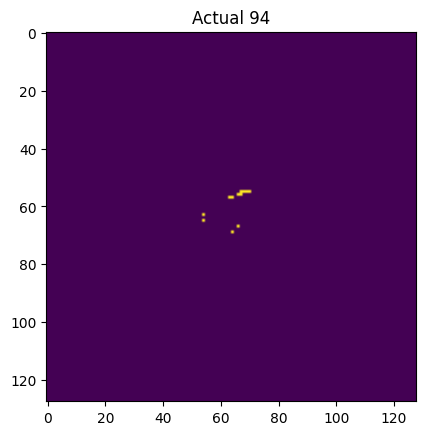

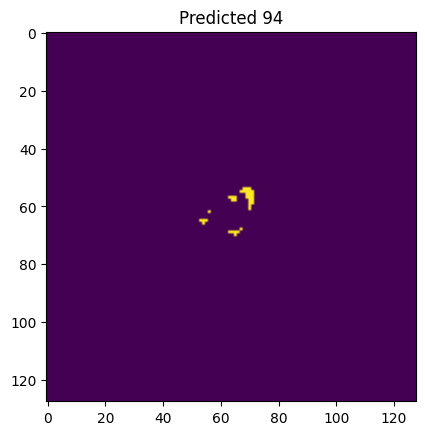

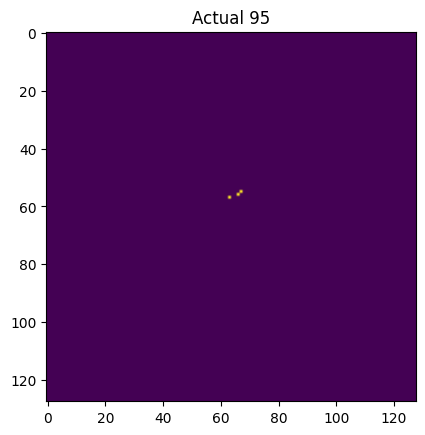

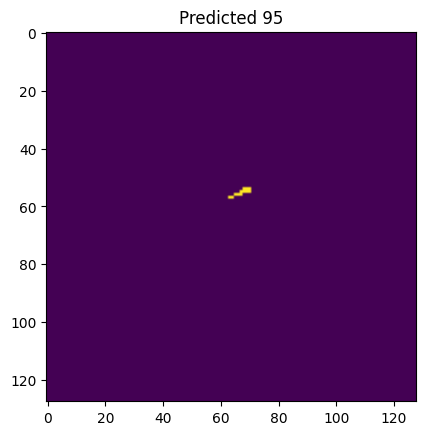

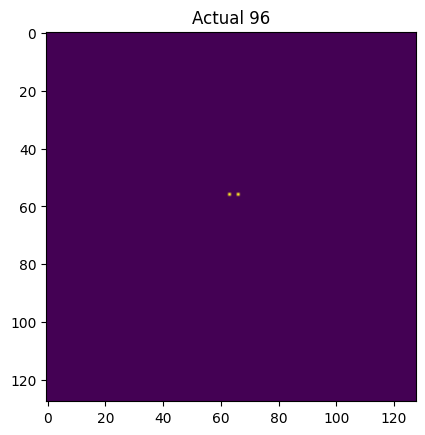

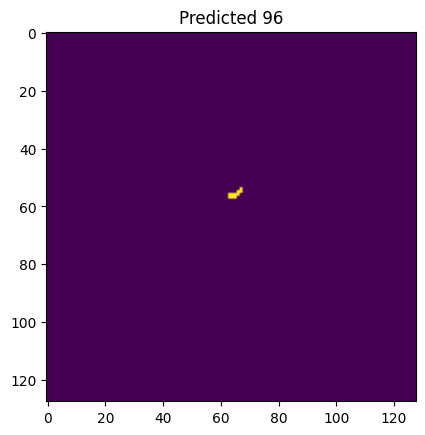

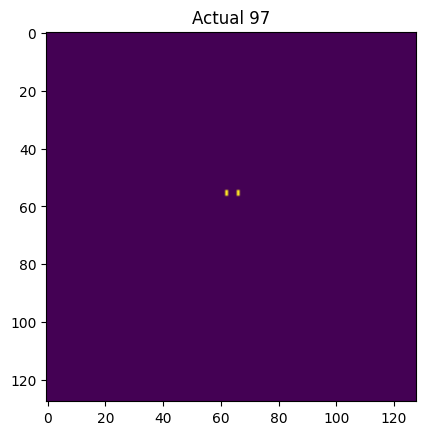

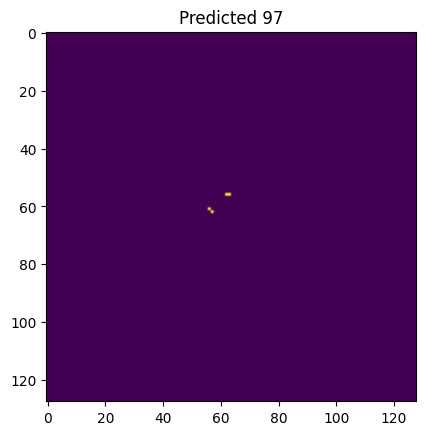

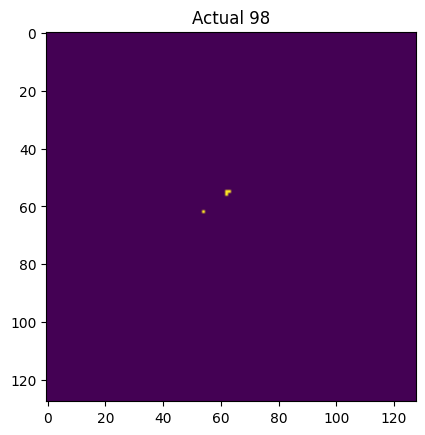

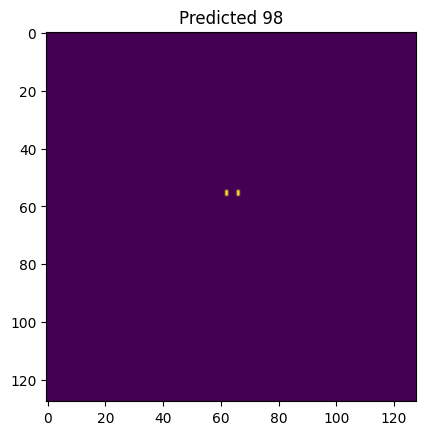

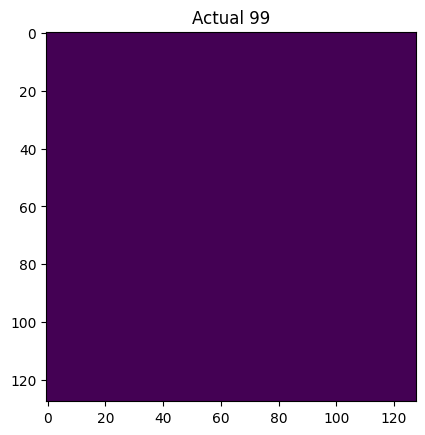

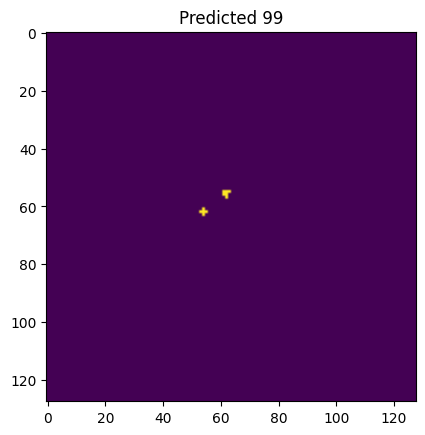

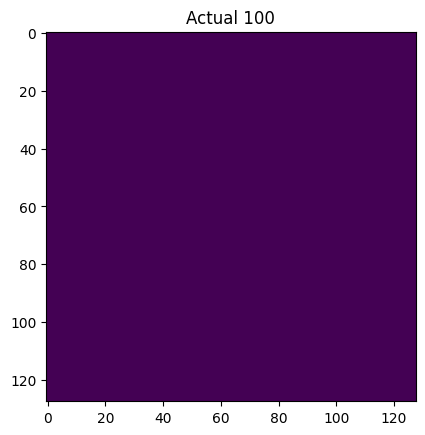

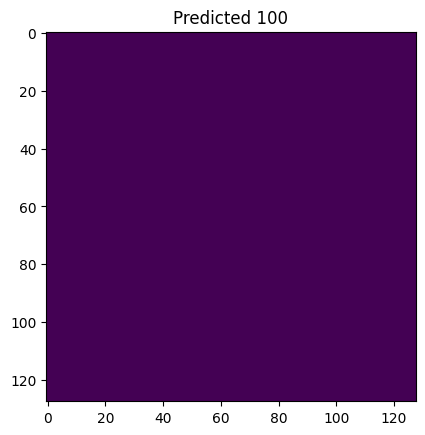

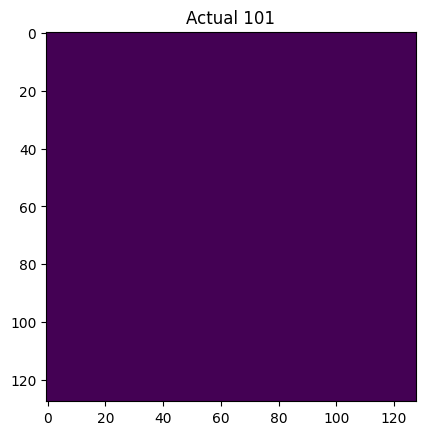

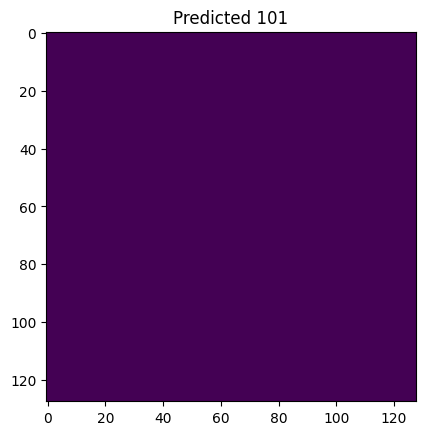

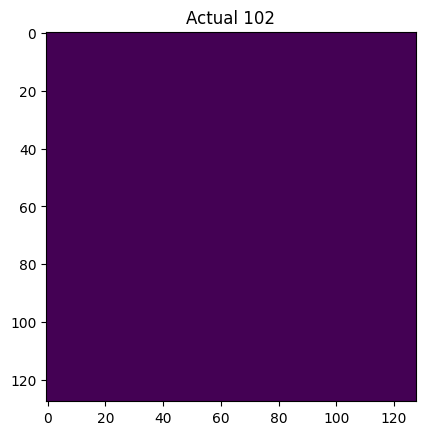

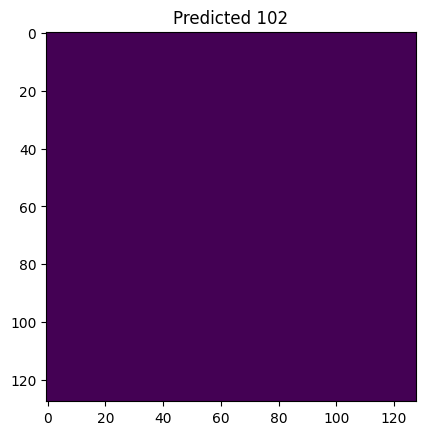

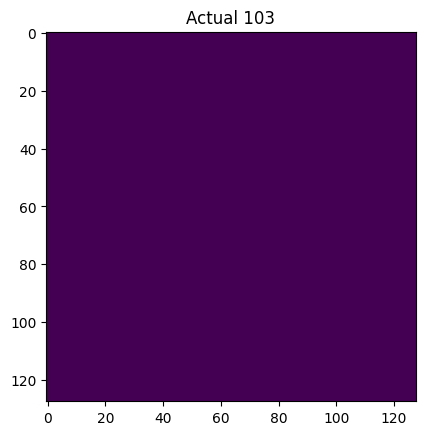

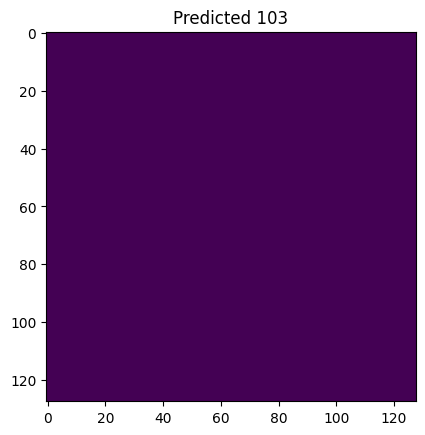

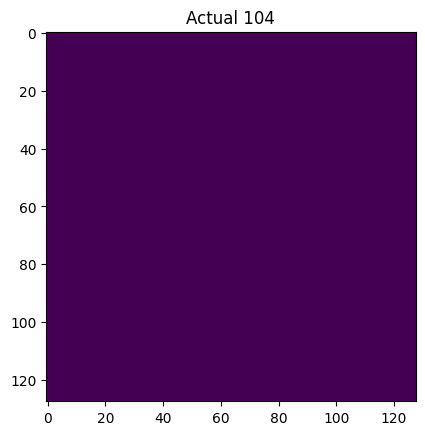

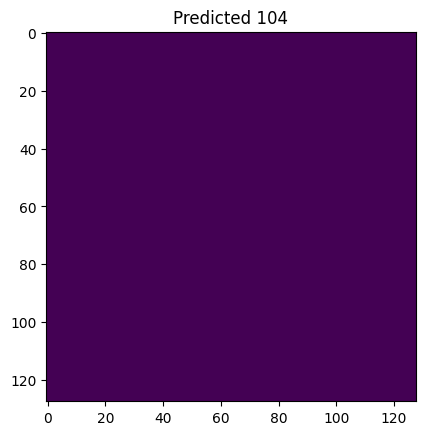

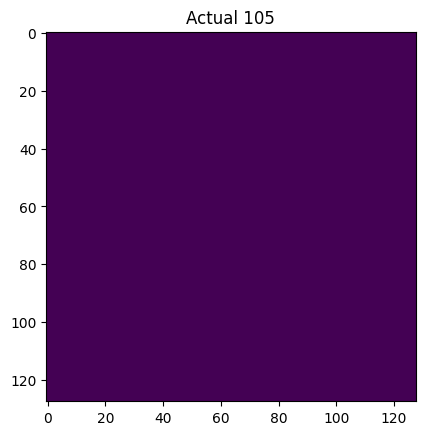

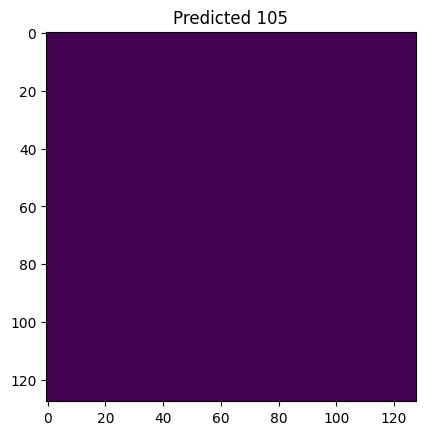

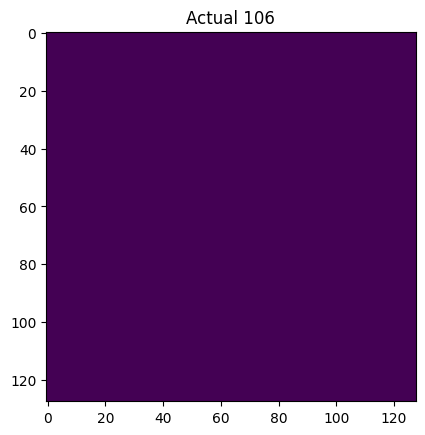

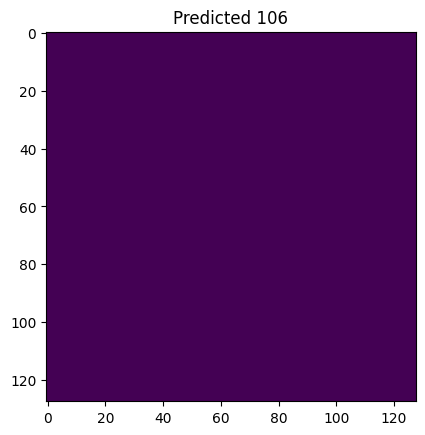

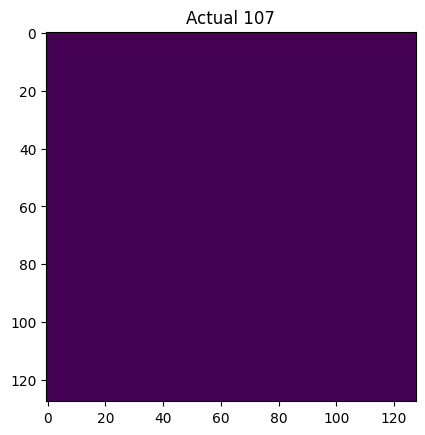

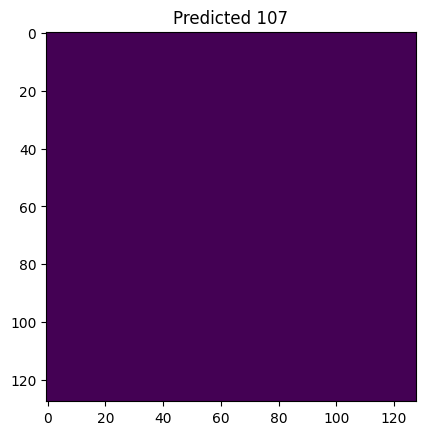

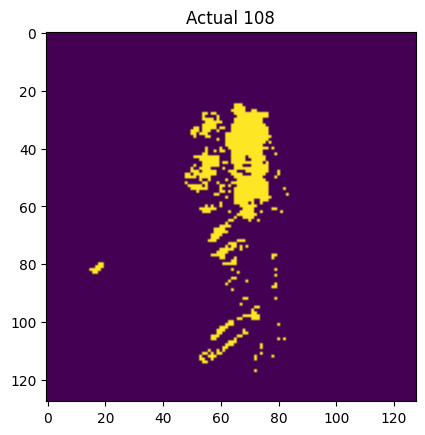

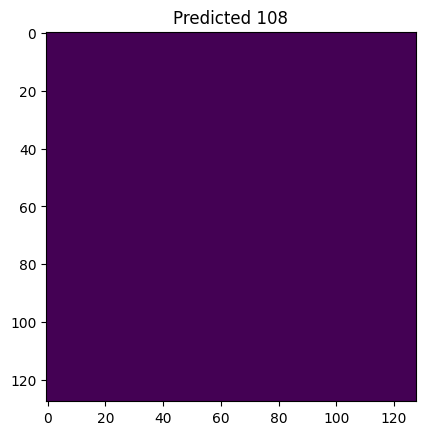

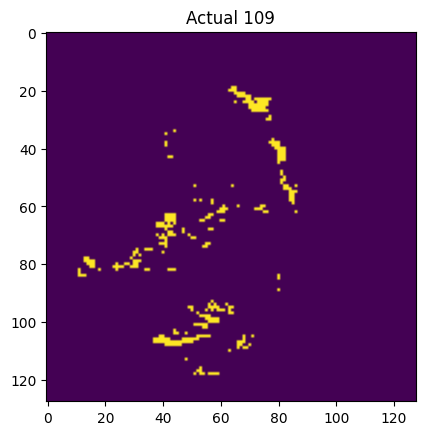

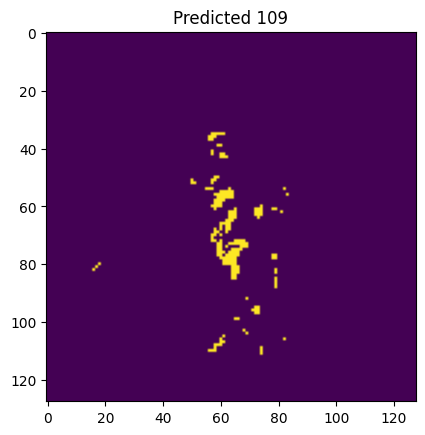

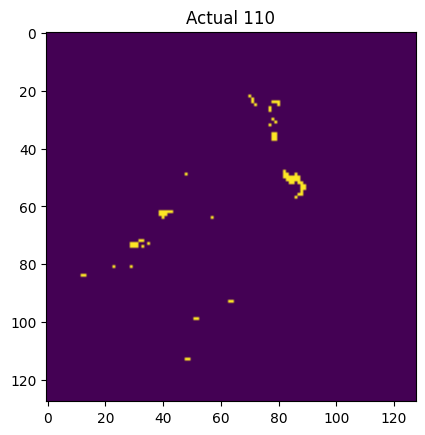

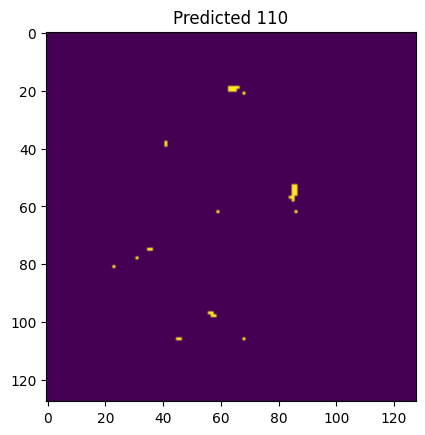

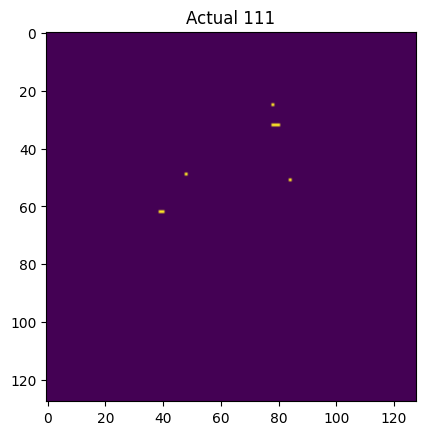

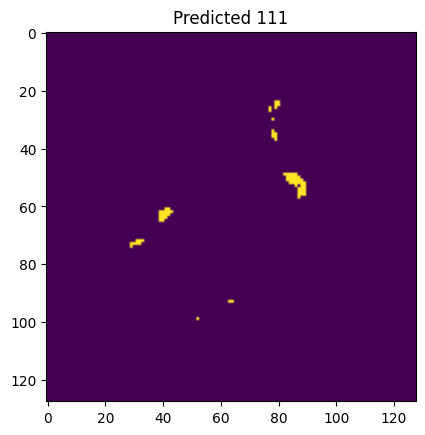

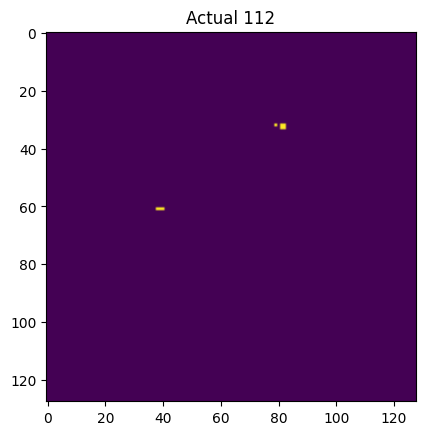

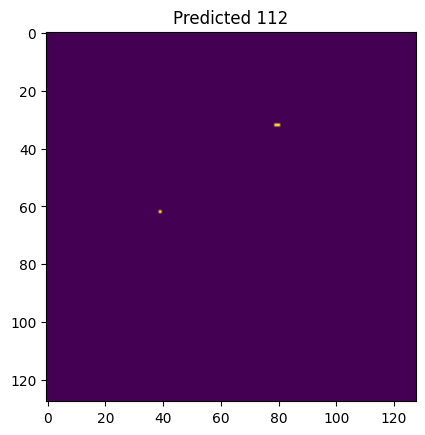

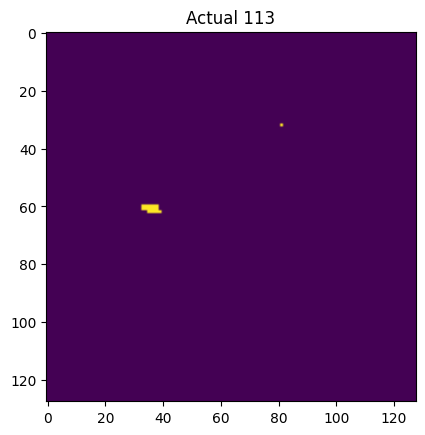

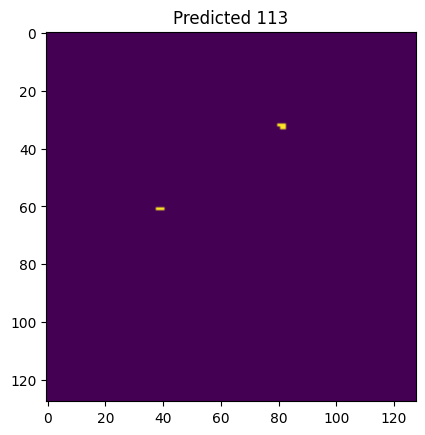

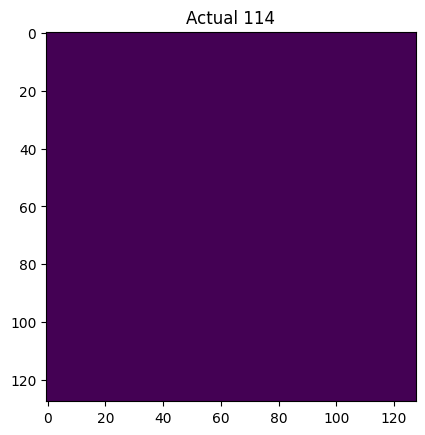

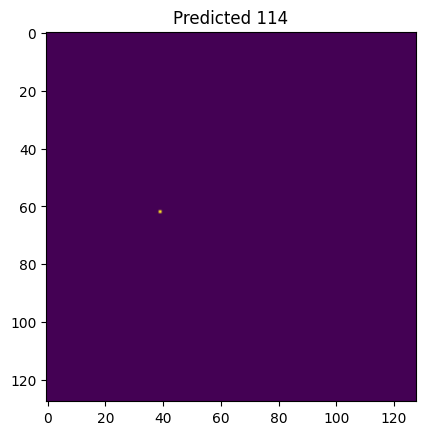

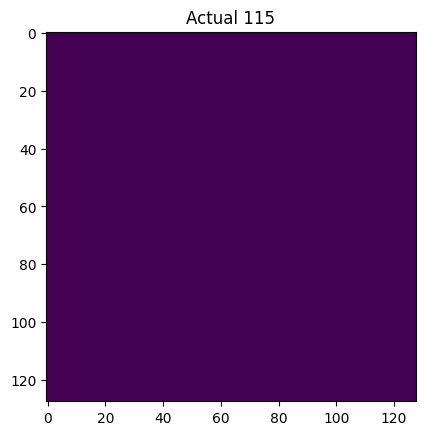

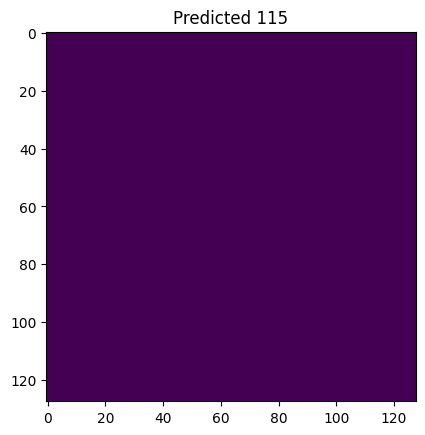

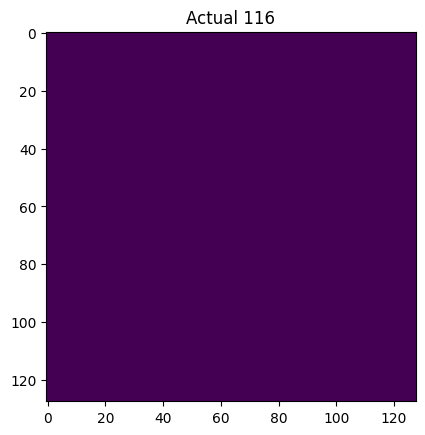

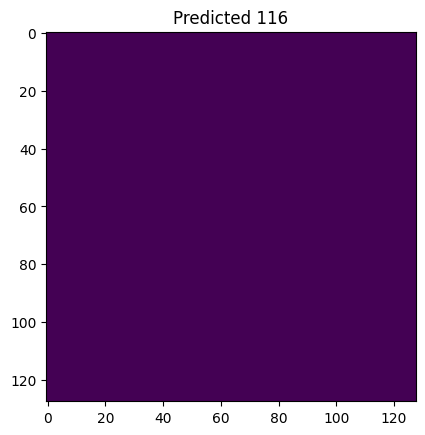

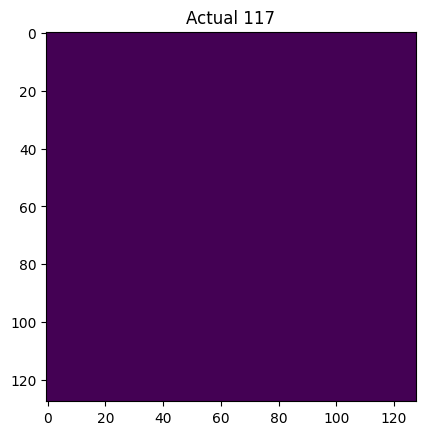

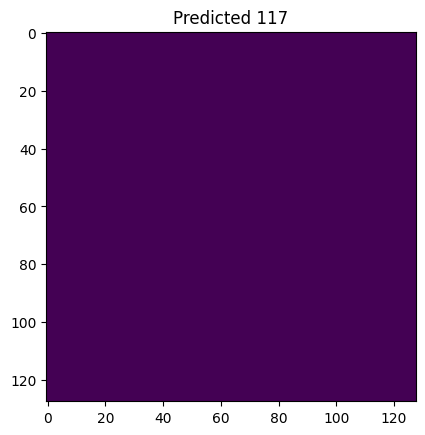

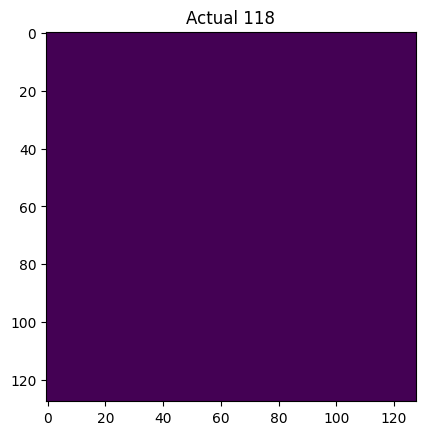

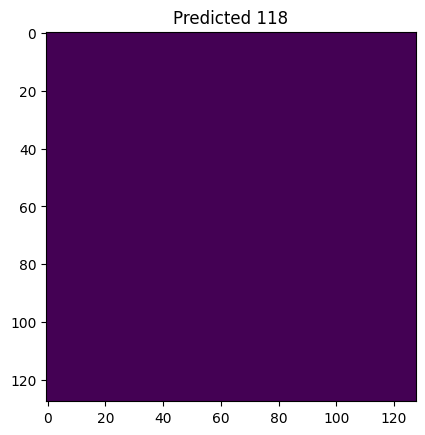

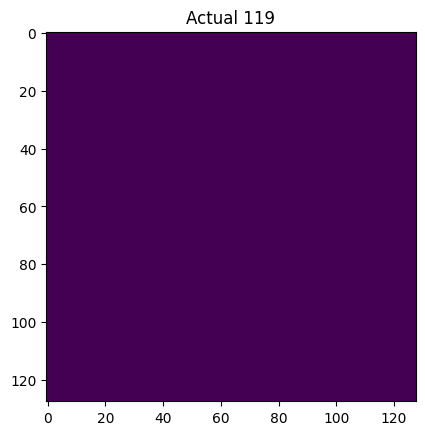

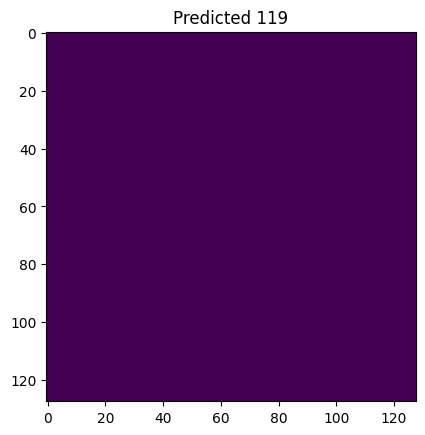

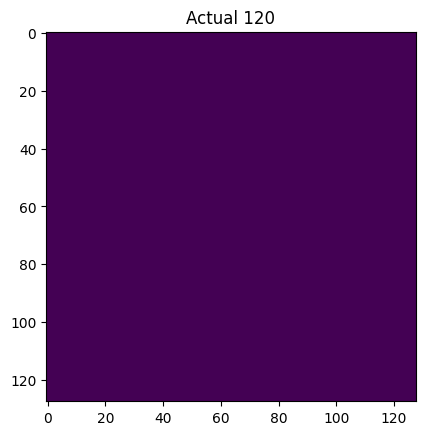

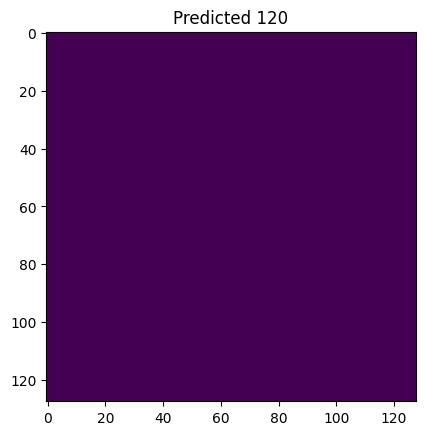

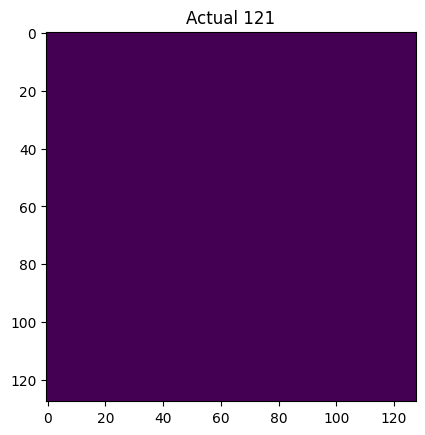

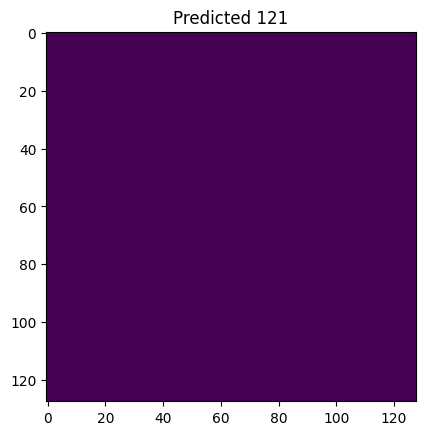

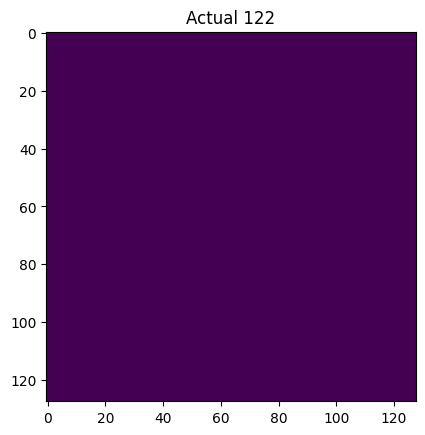

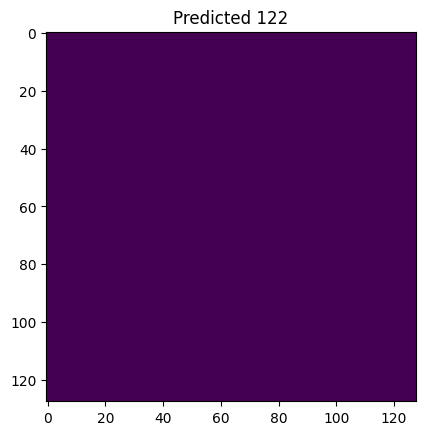

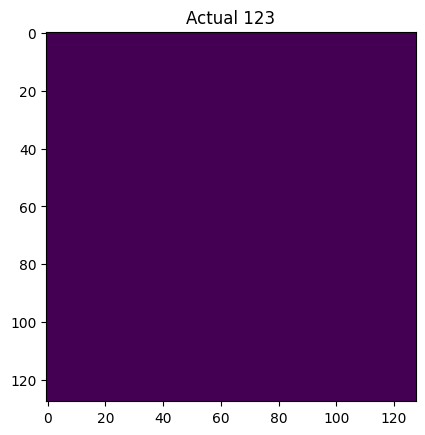

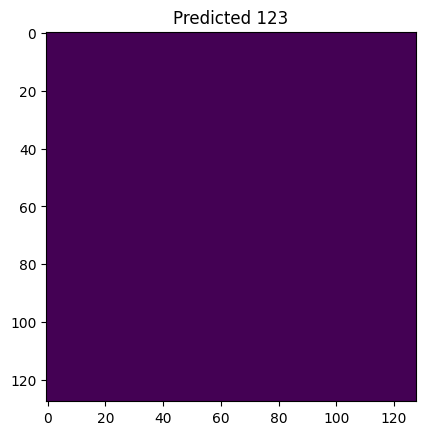

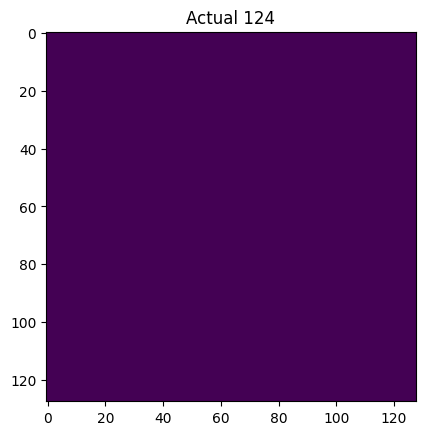

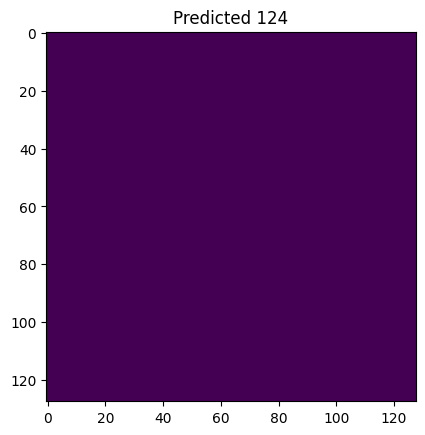

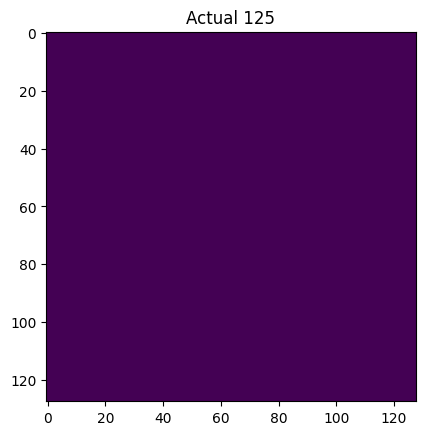

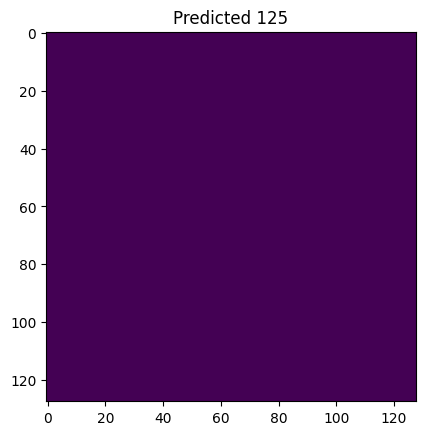

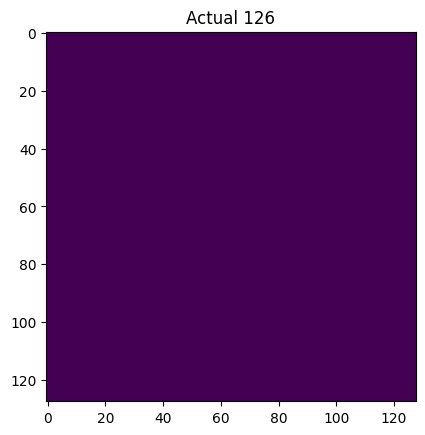

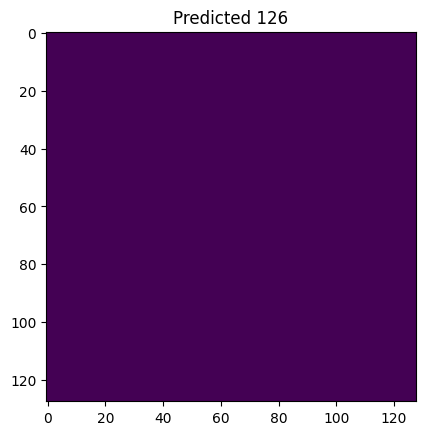

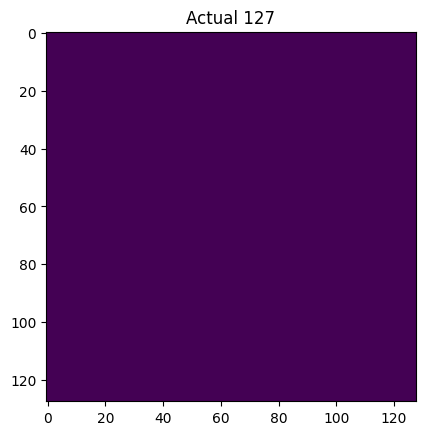

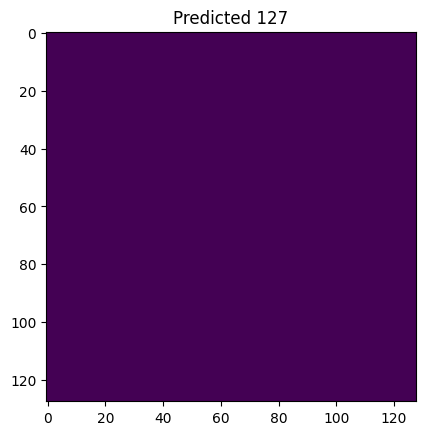

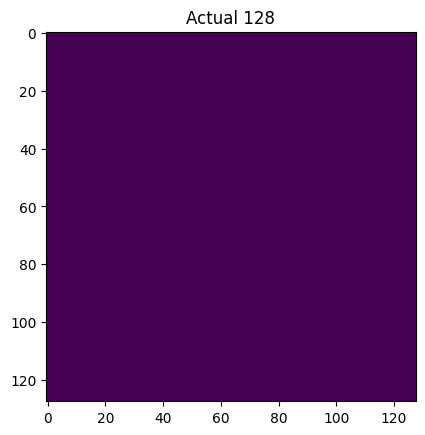

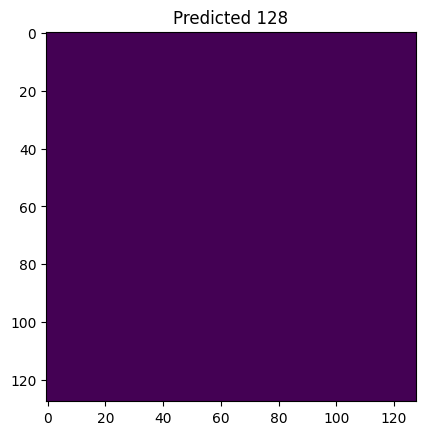

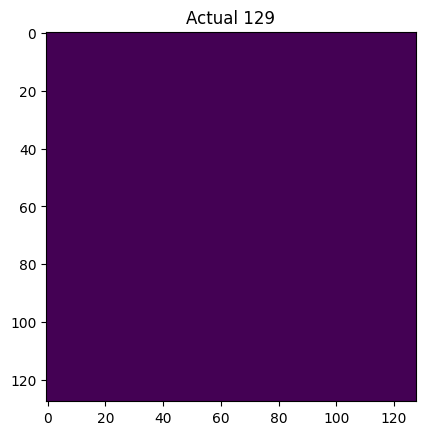

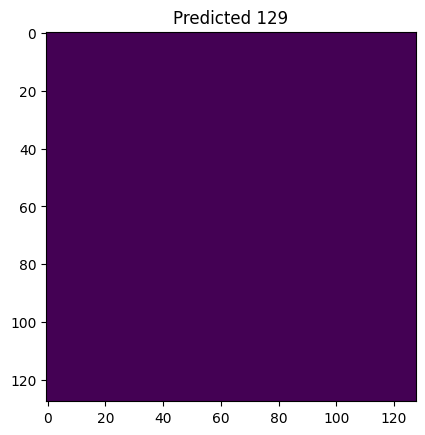

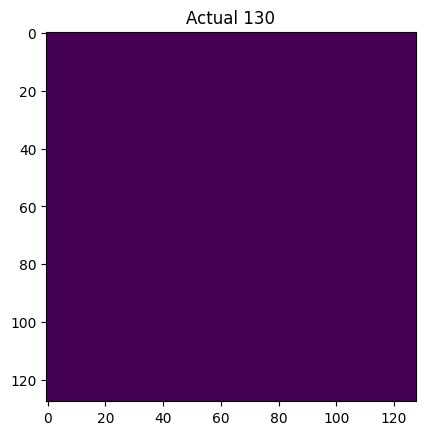

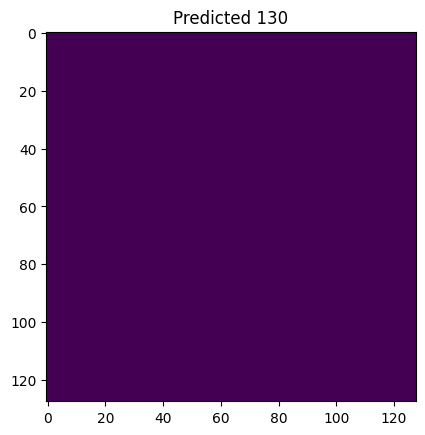

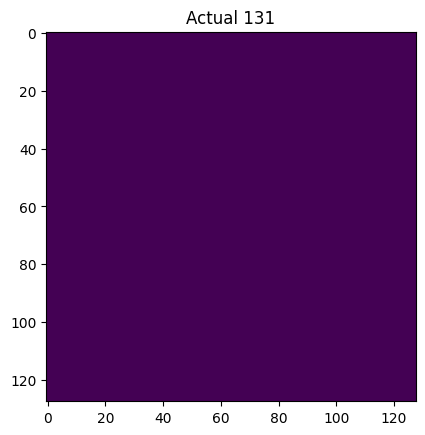

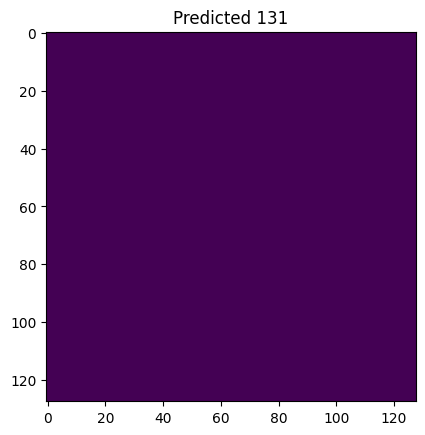

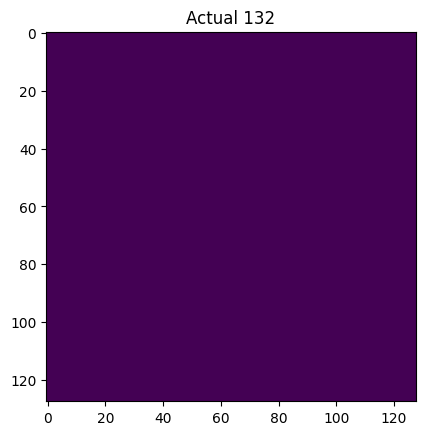

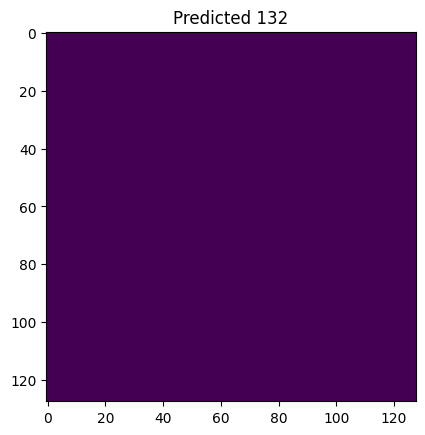

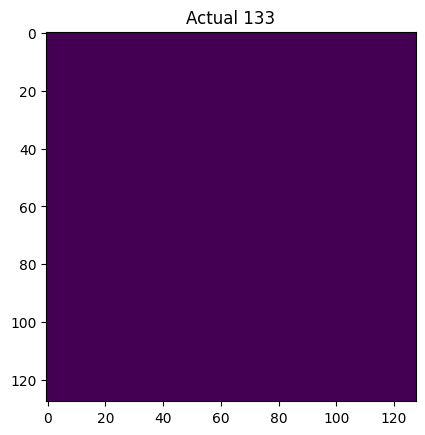

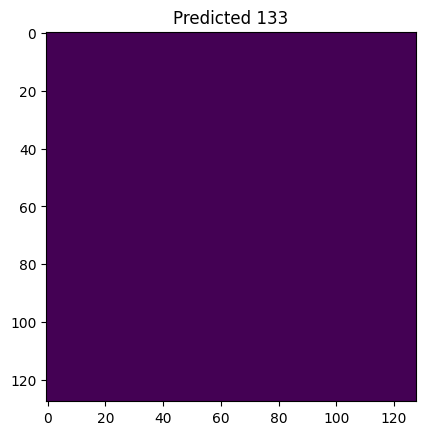

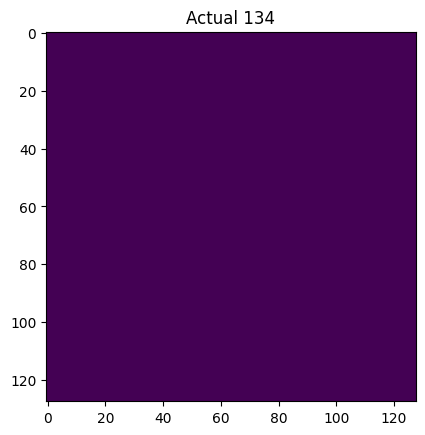

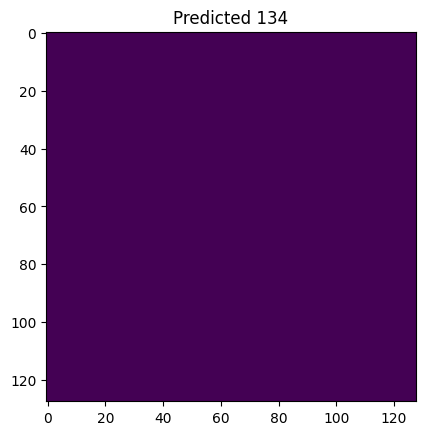

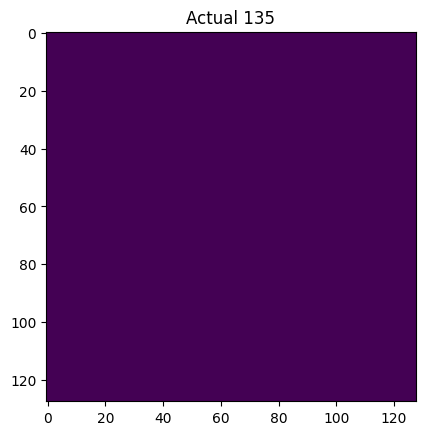

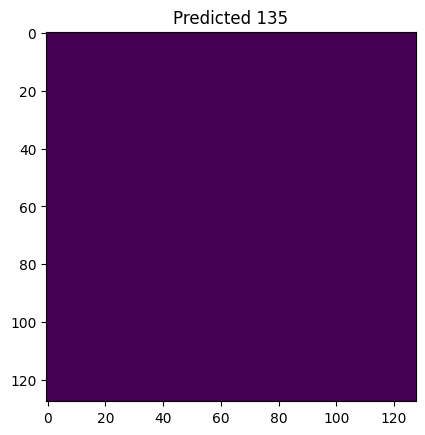

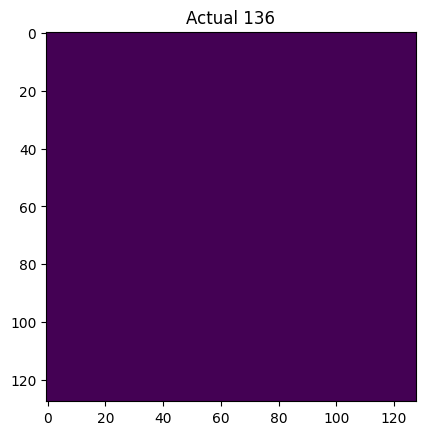

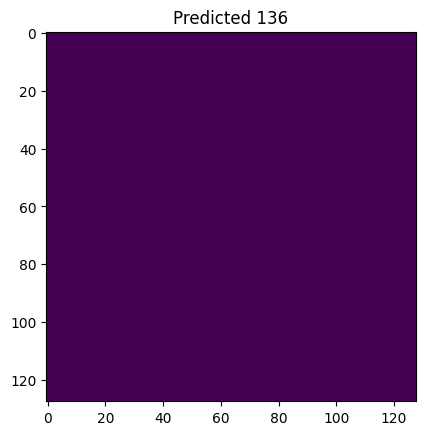

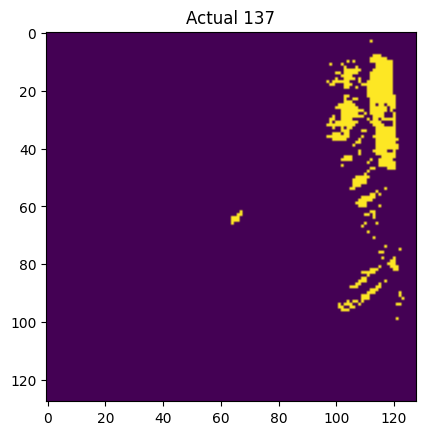

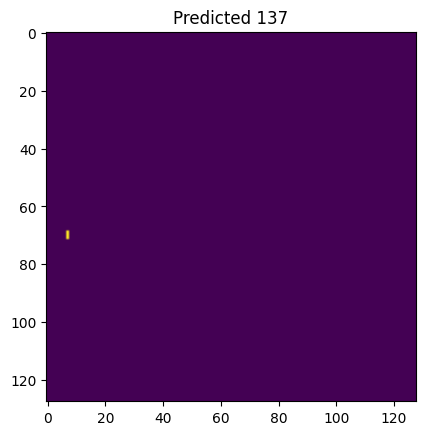

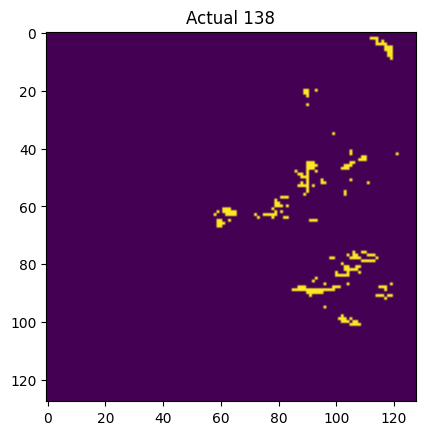

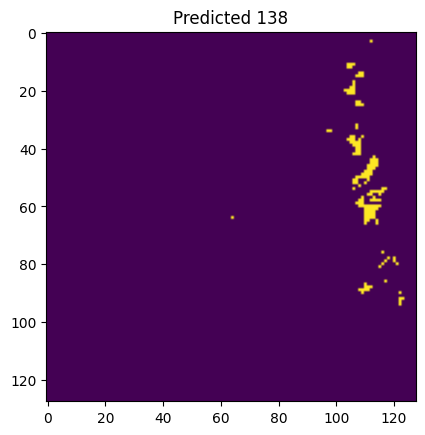

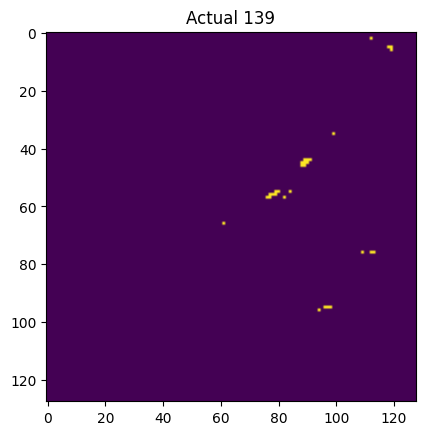

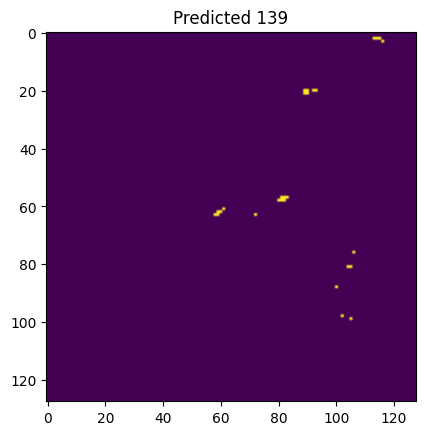

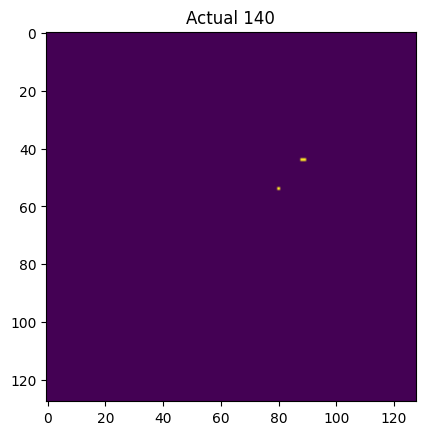

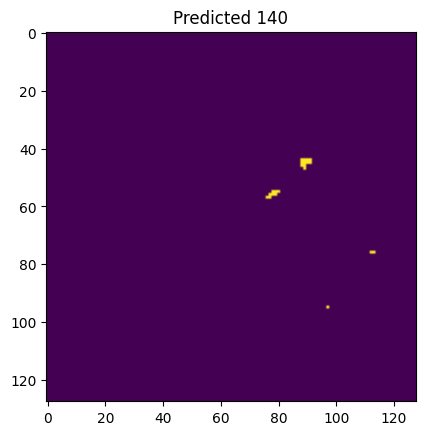

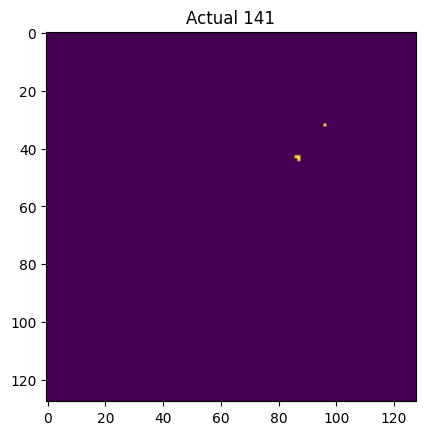

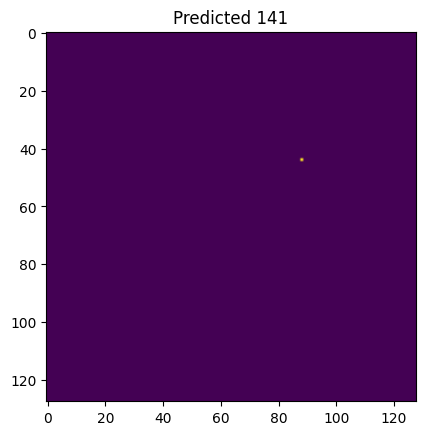

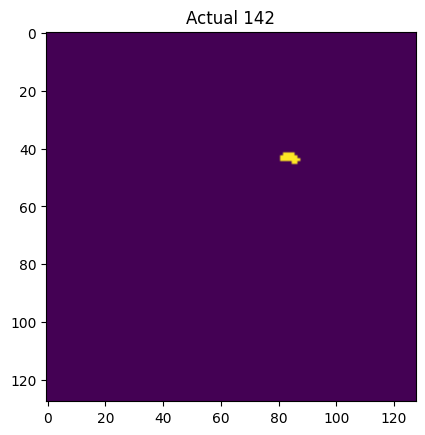

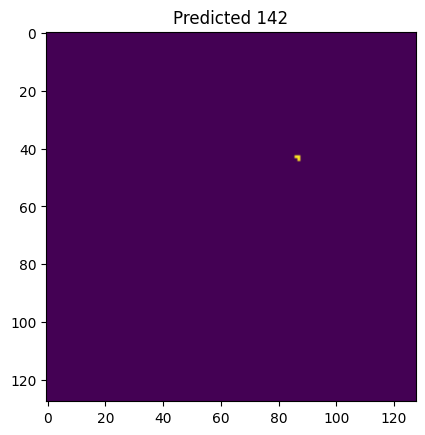

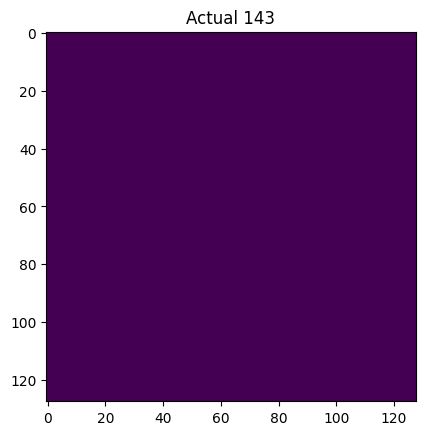

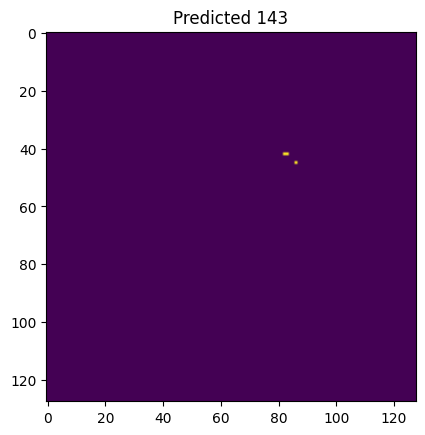

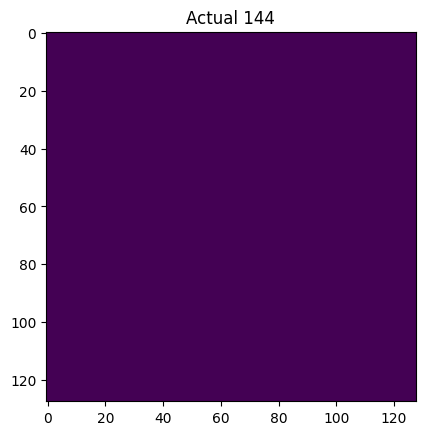

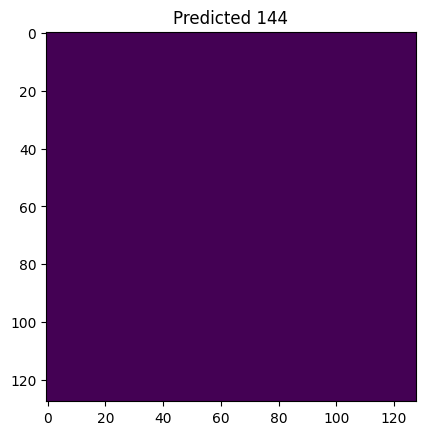

In [15]:
tolerance = 0.01
accuracy = 0
precision = 0
accuracy_counter = 0
precision_counter = 0
show_figures = True
eps = 1e-7
recall = 0
f1 = 0
iou = 0
dice = 0

for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    y_pred = model(x_batch)

    y_batch_np = y_batch.cpu().detach().numpy()
    y_pred_np = y_pred.cpu().detach().numpy()

    for i in range(y_batch_np.shape[0]): # Each image in a batch = batch_size
        split_val = 0.15
        value_true = y_batch_np[i, 0]
        value_true = np.piecewise(value_true, [value_true < split_val, value_true >= split_val], [0, 1])
        if show_figures:
            plt.figure()
            plt.title(f"Actual {precision_counter}")
            plt.imshow(value_true)

        split_val = 0.5
        value_pred = y_pred_np[i, 0]
        value_pred = np.piecewise(value_pred, [value_pred < split_val, value_pred >= split_val], [0, 1])
        if show_figures:
            plt.figure()
            plt.title(f"Predicted {precision_counter}")
            plt.imshow(value_pred)

        correct = np.abs(value_pred - value_true) <= tolerance
        
        accuracy += correct.sum() / correct.size
        accuracy_counter += 1

        TP = np.logical_and(value_pred == 1, value_true == 1).sum()
        FP = np.logical_and(value_pred == 1, value_true == 0).sum()
        FN = np.logical_and(value_pred == 0, value_true == 1).sum()
        TN = np.logical_and(value_pred == 0, value_true == 0).sum()
        
        precision += TP / (TP + FP + 1e-7)  # Add small epsilon to avoid division by zero
        recall += TP / (TP + FN + eps)
        iou += TP / (TP + FP + FN + eps)
        dice += 2 * TP / (2 * TP + FP + FN + eps)
        
        precision_counter += 1
        
avg_accuracy = accuracy / accuracy_counter
avg_precision = precision / precision_counter
avg_recall = recall / precision_counter
avg_iou = iou / precision_counter
avg_dice = dice / precision_counter

f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall + eps)


print(f"Precision: {avg_precision}; Recall: {avg_recall}; IoU: {avg_iou}, Dice: {avg_dice}, F1: {f1}")